<a href="https://colab.research.google.com/github/Sarthak-Chauhan-Git/Drug-induced-cardiotoxicity-classification-model/blob/main/Cardiotoxicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sarthakchauhanml_smiles_dataset_with_fingerprints_rdkit_images_path = kagglehub.dataset_download('sarthakchauhanml/smiles-dataset-with-fingerprints-rdkit-images')

print('Data source import complete.')


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sarthakchauhanml_smiles_dataset_with_fingerprints_rdkit_images_path = kagglehub.dataset_download('sarthakchauhanml/smiles-dataset-with-fingerprints-rdkit-images')

print('Data source import complete.')


Data source import complete.


# 🫀 Cardiotoxicity Classification with Multi-Modal Deep Learning

> **Objective:** Predict whether a chemical compound is cardiotoxic (hERG channel blocker) by fusing two complementary molecular representations — SMILES strings and pre-computed molecular descriptors — through a cross-attention gated deep learning architecture.

---

## 📐 Architecture Overview

```
SMILES  ──► Embedding ──► 1D-CNN ──► AdaptiveMaxPool ──► FC(128) ──► f_s
                                                                         \
                                                            Cross-Attn + Gate ──► FC(64) ──► Sigmoid
                                                                         /
FP desc ──► FC(256) ──► FC(128) ─────────────────────────────────────► f_f
```

| Branch | Input | Output |
|---|---|---|
| SMILES Encoder | Character-tokenised sequence | 128-dim vector `f_s` |
| Fingerprint Encoder | LASSO-selected descriptors | 128-dim vector `f_f` |
| Fusion | Cross-attention + softmax gating | 128-dim fused vector |
| Classifier | Fused vector | Cardiotoxicity probability |

---

## 📂 Dataset
- **SMILES files** (`train_validation_pipe1.csv`, `external_test_set_*.csv`) — columns: `SMILES`, `ACTIVITY`
- **Descriptor files** (`cardiotrain*_merged.csv`, `cardiotest*_merged.csv`) — columns: `Smiles` + ~1800 molecular descriptors


## 1 · Setup — Imports & Reproducibility

In [ ]:
%pip install xgboost --quiet

import os, random, warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score, matthews_corrcoef,
    roc_curve, precision_recall_curve, auc, confusion_matrix,
    average_precision_score,
)
from sklearn.manifold import TSNE

import xgboost as xgb
import shap

warnings.filterwarnings("ignore")

# ── Reproducibility ───────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {DEVICE}")

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"[INFO] Outputs will be saved to: {OUTPUT_DIR}/")


Note: you may need to restart the kernel to use updated packages.
[INFO] Using device: cuda
[INFO] Outputs will be saved to: outputs/


## 2 · Configuration — File Paths & Hyperparameters

Update the paths below to point to your dataset files.

| Variable | Description |
|---|---|
| `SMILES_*` | CSV with `SMILES` + `ACTIVITY` columns |
| `FP_*` | CSV with `Smiles` + descriptor feature columns |
| `MAX_LEN` | Maximum SMILES sequence length for padding |
| `BATCH_SIZE` | Mini-batch size for training |
| `N_EPOCHS` | Maximum training epochs (early stopping applies) |


In [ ]:
# ── Kaggle / local paths — update as needed ──────────────────────
BASE = "/kaggle/input/datasets/sarthakchauhanml/smiles-dataset-with-fingerprints-rdkit-images/Paper_data"

SMILES_TRAIN = f"{BASE}/labeled_data/train/train_validation_pipe1.csv"
SMILES_TEST1 = f"{BASE}/labeled_data/test/external_test_set_neg.csv"
SMILES_TEST2 = f"{BASE}/labeled_data/test/external_test_set_new.csv"
SMILES_TEST3 = f"{BASE}/labeled_data/test/external_test_set_pos.csv"

FP_TRAIN = f"{BASE}/pipeline1_features/train/cardiotrainall_merged.csv"
FP_TEST1 = f"{BASE}/pipeline1_features/test/cardiotestnegall_merged.csv"
FP_TEST2 = f"{BASE}/pipeline1_features/test/cardiotestnewall_merged.csv"
FP_TEST3 = f"{BASE}/pipeline1_features/test/cardiotestposall_merged.csv"

# ── Hyperparameters ───────────────────────────────────────────────
BATCH_SIZE = 64
MAX_LEN    = 120     # SMILES sequence pad/truncate length
N_EPOCHS   = 50      # max epochs (early stopping will trigger sooner)
N_HEADS    = 4       # attention heads in cross-attention module
PATIENCE   = 7       # early stopping patience
LR         = 1e-3
WEIGHT_DECAY = 1e-4

print("[CONFIG] Settings loaded.")


[CONFIG] Settings loaded.


## 3 · Data Loading & Preprocessing

### Strategy
The SMILES files and fingerprint descriptor files are loaded separately and then **aligned by row index** (they correspond 1-to-1). This is necessary because the fingerprint files may use a different SMILES column name (`Smiles` vs `SMILES`) or may lack a SMILES column altogether.

Labels are taken from the SMILES file (`ACTIVITY` column, renamed to `Label`) and attached to the fingerprint data by positional alignment.

**Data flow:**
```
SMILES file  →  SMILES sequences + Label
FP file      →  descriptor matrix (aligned by row) + Label
```


In [ ]:
# ── Helper: detect the SMILES column (handles case variations) ────
def find_smiles_col(df):
    """Return the SMILES column name regardless of case."""
    for c in df.columns:
        if c.strip().upper() == "SMILES":
            return c
    raise ValueError(f"No SMILES column found. Columns: {list(df.columns[:10])}")


def find_label_col(df):
    """Return the label/activity column name."""
    for c in df.columns:
        cu = c.strip().upper()
        if cu in ("ACTIVITY", "LABEL", "CLASS", "TARGET", "Y"):
            return c
    raise ValueError(f"No label column found. Columns: {list(df.columns[:10])}")


# ── Load SMILES files ─────────────────────────────────────────────
def load_smiles_file(path):
    """
    Load a SMILES CSV. Normalises column names to SMILES + Label.
    Returns DataFrame with at minimum ['SMILES', 'Label'] columns.
    """
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()

    smiles_col = find_smiles_col(df)
    label_col  = find_label_col(df)

    df = df.rename(columns={smiles_col: "SMILES", label_col: "Label"})
    df["Label"] = pd.to_numeric(df["Label"], errors="coerce").fillna(0).astype(int)
    return df[["SMILES", "Label"]].reset_index(drop=True)


# ── Load fingerprint / descriptor files ───────────────────────────
def load_fp_file(fp_path, smiles_df):
    """
    Load a descriptor CSV.
    Labels are aligned by row index from the companion SMILES DataFrame.

    Handles two cases:
      (a) FP file has its own SMILES column → inner-merge on SMILES
      (b) FP file has no SMILES column     → row-wise concatenation

    In either case the returned DataFrame has:
      - All descriptor feature columns
      - 'SMILES'  column
      - 'Label'   column
    """
    fp_df = pd.read_csv(fp_path)
    fp_df.columns = fp_df.columns.str.strip()

    # Try to find a SMILES column in the FP file
    try:
        smiles_col_fp = find_smiles_col(fp_df)
        fp_df = fp_df.rename(columns={smiles_col_fp: "SMILES"})
        # Merge on SMILES string
        merged = fp_df.merge(smiles_df[["SMILES", "Label"]], on="SMILES", how="inner")
        print(f"  [load_fp] Merged on SMILES: {len(merged)} rows  ({fp_path.split('/')[-1]})")
    except ValueError:
        # No SMILES column in FP file — align by row index
        n = min(len(fp_df), len(smiles_df))
        merged = fp_df.iloc[:n].copy().reset_index(drop=True)
        merged["SMILES"] = smiles_df["SMILES"].iloc[:n].values
        merged["Label"]  = smiles_df["Label"].iloc[:n].values
        print(f"  [load_fp] Row-aligned: {n} rows  ({fp_path.split('/')[-1]})")

    # Drop any rows where Label is NaN
    merged = merged.dropna(subset=["Label"]).reset_index(drop=True)
    merged["Label"] = merged["Label"].astype(int)
    return merged


# ── Execute data loading ───────────────────────────────────────────
print("Loading SMILES files...")
df_train_s = load_smiles_file(SMILES_TRAIN)
df_t1_s    = load_smiles_file(SMILES_TEST1)
df_t2_s    = load_smiles_file(SMILES_TEST2)
df_t3_s    = load_smiles_file(SMILES_TEST3)

print("\nLoading fingerprint/descriptor files...")
df_train_fp = load_fp_file(FP_TRAIN, df_train_s)
df_t1_fp    = load_fp_file(FP_TEST1,  df_t1_s)
df_t2_fp    = load_fp_file(FP_TEST2,  df_t2_s)
df_t3_fp    = load_fp_file(FP_TEST3,  df_t3_s)

# ── Extract label arrays ──────────────────────────────────────────
y_train = df_train_fp["Label"].values.astype(np.float32)
y_t1    = df_t1_fp["Label"].values.astype(np.float32)
y_t2    = df_t2_fp["Label"].values.astype(np.float32)
y_t3    = df_t3_fp["Label"].values.astype(np.float32)

print(f"\n{'Dataset':<12} {'N':>6} {'Toxic %':>8}")
print("-" * 28)
for nm, y in [("Train", y_train), ("Test1", y_t1), ("Test2", y_t2), ("Test3", y_t3)]:
    print(f"{nm:<12} {len(y):>6} {y.mean():>7.1%}")


Loading SMILES files...

Loading fingerprint/descriptor files...
  [load_fp] Merged on SMILES: 12620 rows  (cardiotrainall_merged.csv)
  [load_fp] Merged on SMILES: 41 rows  (cardiotestnegall_merged.csv)
  [load_fp] Merged on SMILES: 740 rows  (cardiotestnewall_merged.csv)
  [load_fp] Merged on SMILES: 44 rows  (cardiotestposall_merged.csv)

Dataset           N  Toxic %
----------------------------
Train         12620   52.6%
Test1            41   26.8%
Test2           740    4.6%
Test3            44   68.2%


### 3.1 · Class Distribution

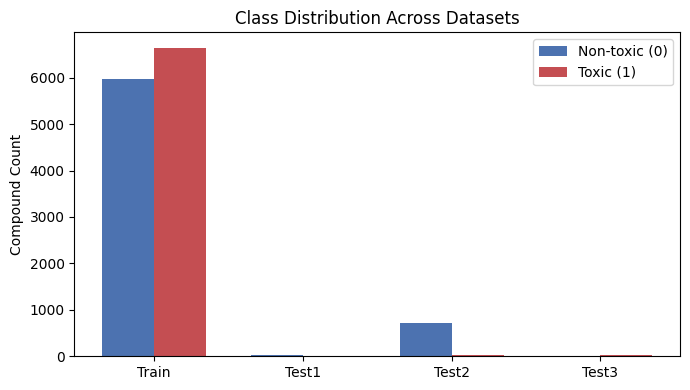

In [ ]:
def plot_class_distribution(labels_dict, save_path):
    sets      = list(labels_dict.keys())
    pos_counts = [int(labels_dict[k].sum()) for k in sets]
    neg_counts = [len(labels_dict[k]) - int(labels_dict[k].sum()) for k in sets]

    x, width = np.arange(len(sets)), 0.35
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(x - width/2, neg_counts, width, label="Non-toxic (0)", color="#4C72B0")
    ax.bar(x + width/2, pos_counts, width, label="Toxic (1)",     color="#C44E52")
    ax.set_xticks(x); ax.set_xticklabels(sets)
    ax.set_ylabel("Compound Count")
    ax.set_title("Class Distribution Across Datasets")
    ax.legend(); plt.tight_layout()
    plt.savefig(save_path, dpi=150); plt.show(); plt.close()

plot_class_distribution(
    {"Train": y_train, "Test1": y_t1, "Test2": y_t2, "Test3": y_t3},
    f"{OUTPUT_DIR}/class_distribution.png"
)


## 4 · SMILES Tokenisation

SMILES strings are treated as **character-level sequences**. Each unique character in the training set becomes a vocabulary token. Sequences are padded (or truncated) to `MAX_LEN = 120` characters.

> Example: `CC(=O)Oc1ccccc1C(=O)O` → `[3, 3, 11, 2, 15, 5, ...]` (integer indices)


In [ ]:
class SMILESTokenizer:
    """Character-level tokeniser for SMILES strings."""
    PAD = 0

    def __init__(self):
        self.char2idx  = {}
        self.vocab_size = 0

    def fit(self, smiles_list):
        chars = set()
        for s in smiles_list:
            chars.update(list(str(s)))
        self.char2idx  = {c: i + 1 for i, c in enumerate(sorted(chars))}
        self.vocab_size = len(self.char2idx)
        return self

    def encode(self, smiles_list, max_len=120):
        seqs = []
        for s in smiles_list:
            ids = [self.char2idx.get(c, 0) for c in str(s)[:max_len]]
            ids = ids + [0] * max(0, max_len - len(ids))   # pad
            seqs.append(ids)
        return np.array(seqs, dtype=np.int64)

# ── Fit on training SMILES only ───────────────────────────────────
tokenizer = SMILESTokenizer()
tokenizer.fit(df_train_fp["SMILES"].tolist())
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size : {VOCAB_SIZE} unique characters")

# ── Encode all sets ───────────────────────────────────────────────
X_seq_train = tokenizer.encode(df_train_fp["SMILES"].tolist(), MAX_LEN)
X_seq_t1    = tokenizer.encode(df_t1_fp["SMILES"].tolist(),    MAX_LEN)
X_seq_t2    = tokenizer.encode(df_t2_fp["SMILES"].tolist(),    MAX_LEN)
X_seq_t3    = tokenizer.encode(df_t3_fp["SMILES"].tolist(),    MAX_LEN)

print(f"X_seq_train shape : {X_seq_train.shape}")
print(f"X_seq_test1 shape : {X_seq_t1.shape}")


Vocabulary size : 37 unique characters
X_seq_train shape : (12620, 120)
X_seq_test1 shape : (41, 120)


## 5 · Fingerprint Descriptor Selection via LASSO

### How LASSO Is Applied

**Input:** Raw descriptor matrix `X_fp_train_raw` — shape `(N_train, ~1800)` — containing Mordred, PubChem, and MACCS fingerprint features.

**Step-by-step process:**

1. **StandardScaler** normalises each feature to zero mean and unit variance (required because LASSO penalises coefficients and unscaled features bias it toward low-variance columns).
2. **LassoCV** fits a linear model with L1 regularisation (α selected via 5-fold CV across 50 log-spaced values in `[1e-4, 1e-1]`). The L1 penalty drives irrelevant feature coefficients **exactly to zero**.
3. A **binary mask** `lasso_mask` is extracted: `True` for any feature with a non-zero coefficient.
4. The same `StandardScaler` (fit only on training data) transforms test sets, then `lasso_mask` filters them — **no data leakage**.
5. A **fallback** keeps at least 10 features if LASSO zeros everything (rare with high α).

```
X_fp_train_raw  (N, ~1800)
       ↓  StandardScaler.fit_transform
X_fp_train_sc   (N, ~1800)
       ↓  LassoCV(cv=5).fit → lasso_mask (bool array)
X_fp_train      (N, FP_DIM)   ← deep learning model input
```

> **Why regression LASSO on binary labels?** This is valid as a *feature selector* — L1 regression identifies the linearly-most-discriminative descriptors, which are then passed to the non-linear deep model. Coefficients reflect linear predictive strength; a zero coefficient means the feature adds no marginal linear signal.

In [ ]:
# ── Step 1: identify purely numeric descriptor columns ───────────
# Some CSVs mix in string metadata columns (e.g. notes like
# 'multiple fragments (SpAbs_A/SpAbs)'). We keep only columns
# that are numeric across ALL four datasets.

non_feat_cols = {"SMILES", "Label"}

def get_numeric_fp_cols(df_train_fp, df_t1_fp, df_t2_fp, df_t3_fp):
    """
    Return descriptor column names that are:
      1. Present in all four DataFrames
      2. Fully numeric in the training set (no string values)
      3. Non-zero variance in the training set
    """
    candidates = [c for c in df_train_fp.columns if c not in non_feat_cols]

    # Keep only columns present in every test set too
    for df in [df_t1_fp, df_t2_fp, df_t3_fp]:
        test_cols = set(df.columns)
        candidates = [c for c in candidates if c in test_cols]

    # Coerce to numeric; drop columns with any non-numeric values
    train_sub = df_train_fp[candidates].apply(pd.to_numeric, errors="coerce")
    all_numeric = train_sub.columns[train_sub.notna().all()].tolist()

    # Drop zero-variance (constant) columns
    non_const = [c for c in all_numeric if train_sub[c].std() > 0]

    dropped_str = len(candidates)  - len(all_numeric)
    dropped_var = len(all_numeric) - len(non_const)
    print(f"[FP cols] Candidates        : {len(candidates)}")
    print(f"[FP cols] Dropped (non-numeric): {dropped_str}")
    print(f"[FP cols] Dropped (zero-var)   : {dropped_var}")
    print(f"[FP cols] Remaining            : {len(non_const)}")
    return non_const

fp_cols = get_numeric_fp_cols(df_train_fp, df_t1_fp, df_t2_fp, df_t3_fp)

# ── Step 2: build raw float matrices ──────────────────────────────
def safe_fp_matrix(df, cols):
    """Coerce to numeric, fill NaN with 0, return float32 array."""
    return (df[cols]
            .apply(pd.to_numeric, errors="coerce")
            .fillna(0)
            .values.astype(np.float32))

X_fp_train_raw = safe_fp_matrix(df_train_fp, fp_cols)
X_fp_t1_raw   = safe_fp_matrix(df_t1_fp,    fp_cols)
X_fp_t2_raw   = safe_fp_matrix(df_t2_fp,    fp_cols)
X_fp_t3_raw   = safe_fp_matrix(df_t3_fp,    fp_cols)
print(f"Raw descriptor matrix shape (train): {X_fp_train_raw.shape}")

# ── Step 3: LASSO feature selection ───────────────────────────────
def lasso_select(X_train, y_train, X_tests, alphas=None):
    """
    Fit LassoCV on standardised training descriptors.
    Returns selected subsets for train + all test sets.
    Includes inf/nan cleanup after scaling.
    """
    if alphas is None:
        alphas = np.logspace(-4, -1, 50)

    scaler = StandardScaler()
    X_tr_sc = scaler.fit_transform(X_train)
    X_tr_sc = np.nan_to_num(X_tr_sc, nan=0.0, posinf=0.0, neginf=0.0)

    print("[LASSO] Fitting LassoCV (this may take 1-2 min)...")
    lasso = LassoCV(cv=5, alphas=alphas, max_iter=10000, random_state=SEED, n_jobs=-1)
    lasso.fit(X_tr_sc, y_train)

    mask = lasso.coef_ != 0
    print(f"[LASSO] Selected {mask.sum()} / {X_train.shape[1]} features  "
          f"(alpha = {lasso.alpha_:.5f})")

    # Fallback: if LASSO zeros everything out, use top-10 by |coef|
    if mask.sum() == 0:
        print("[LASSO] Warning: 0 features selected — falling back to top-10 by |coef|")
        top10 = np.argsort(np.abs(lasso.coef_))[-10:]
        mask[top10] = True

    X_tr_sel    = X_tr_sc[:, mask]
    X_tests_sel = []
    for Xt in X_tests:
        Xt_sc = np.nan_to_num(scaler.transform(Xt), nan=0.0, posinf=0.0, neginf=0.0)
        X_tests_sel.append(Xt_sc[:, mask])

    return X_tr_sel, X_tests_sel, mask, scaler

X_fp_train, (X_fp_t1, X_fp_t2, X_fp_t3), lasso_mask, fp_scaler = lasso_select(
    X_fp_train_raw, y_train,
    [X_fp_t1_raw, X_fp_t2_raw, X_fp_t3_raw]
)

FP_DIM = X_fp_train.shape[1]
sel_feature_names = [fp_cols[i] for i in range(len(fp_cols)) if lasso_mask[i]]
print(f"FP_DIM (model input) : {FP_DIM}")
print(f"Example selected features: {sel_feature_names[:5]}")


[FP cols] Candidates        : 2660
[FP cols] Dropped (non-numeric): 745
[FP cols] Dropped (zero-var)   : 374
[FP cols] Remaining            : 1541
Raw descriptor matrix shape (train): (12620, 1541)
[LASSO] Fitting LassoCV (this may take 1-2 min)...
[LASSO] Selected 900 / 1541 features  (alpha = 0.00027)
FP_DIM (model input) : 900
Example selected features: ['nAcid', 'nSpiro', 'nBridgehead', 'nF', 'nI']


## 6 · Model Architecture

### 6.1 SMILES Branch — 1D-CNN Sequence Encoder
Learns local chemical motif patterns from character sequences through two convolutional layers followed by global max-pooling.

### 6.2 Fingerprint Branch — MLP Descriptor Encoder  
Two fully-connected layers with BatchNorm and Dropout map the selected descriptors to a 128-dimensional embedding.

### 6.3 Cross-Attention Fusion
Both branch outputs are treated as query/key/value pairs in a multi-head attention block:
- SMILES features **attend** to fingerprint features → `f_s'`
- Fingerprint features **attend** to SMILES features → `f_f'`

### 6.4 Softmax Gating
A small linear network maps the concatenated attended vectors to scalar gates `(g_s, g_f)` via softmax, ensuring `g_s + g_f = 1`. The final fused vector is:

$$F = g_s \cdot f_s' + g_f \cdot f_f'$$

The gate values reveal which modality the model relies on for each prediction.


## 6 · Four Fusion Mechanisms

We implement and compare **four distinct fusion strategies** that combine the SMILES branch embedding `f_s` and the fingerprint branch embedding `f_f`:

| Fusion | Description |
|---|---|
| **Concatenation** | Direct concat `[f_s; f_f]` → Linear(256,128) — no cross-modal interaction |
| **Attention-only** | Cross-attention between branches, sum of attended outputs |
| **Gate-only** | Softmax gating `g_s·f_s + g_f·f_f` — weighted combination without attention |
| **Gated-Attention** | Cross-attention + softmax gating (full model) — attended features are gated |

The comparison table in Section 15 reports all four on the external test sets.

In [ ]:
# ═══════════════════════════════════════════════════════════════
# §6 — Four Fusion Variants
# ═══════════════════════════════════════════════════════════════

class SequenceBranch(nn.Module):
    """SMILES → Embedding → Conv1D ×2 → AdaptiveMaxPool → FC(128) + LayerNorm"""
    def __init__(self, vocab_size, embed_dim=64, conv_channels=128, kernel_size=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.conv1   = nn.Conv1d(embed_dim, conv_channels, kernel_size, padding=kernel_size//2)
        self.conv2   = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.pool    = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc      = nn.Linear(conv_channels, 128)
        self.norm    = nn.LayerNorm(128)

    def forward(self, x):
        e = self.embedding(x).permute(0, 2, 1)
        e = F.relu(self.conv1(e))
        e = F.relu(self.conv2(e))
        e = self.pool(e).squeeze(2)
        e = self.dropout(e)
        return self.norm(F.relu(self.fc(e)))


class FingerprintBranch(nn.Module):
    """Descriptor → FC(512) → FC(256) → FC(128) + residual skip + LayerNorm"""
    def __init__(self, in_dim):
        super().__init__()
        self.fc1     = nn.Linear(in_dim, 512)
        self.bn1     = nn.BatchNorm1d(512)
        self.fc2     = nn.Linear(512, 256)
        self.bn2     = nn.BatchNorm1d(256)
        self.fc3     = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)
        self.norm    = nn.LayerNorm(128)
        self.skip    = nn.Linear(in_dim, 128, bias=False)

    def forward(self, x):
        residual = self.skip(x)
        x = self.bn1(F.relu(self.fc1(x))); x = self.dropout(x)
        x = self.bn2(F.relu(self.fc2(x))); x = self.dropout(x)
        return self.norm(F.relu(self.fc3(x) + residual))


# ── Fusion 1: Direct Concatenation ───────────────────────────────
class ConcatFusionNet(nn.Module):
    """Concat [f_s ; f_f] → Linear(256,128) — no cross-modal interaction."""
    def __init__(self, vocab_size, fp_dim, embed_dim=64, conv_ch=128, n_heads=4):
        super().__init__()
        self.seq_branch = SequenceBranch(vocab_size, embed_dim, conv_ch)
        self.fp_branch  = FingerprintBranch(fp_dim)
        self.fusion     = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(), nn.LayerNorm(128), nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32),  nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1),   nn.Sigmoid(),
        )

    def forward(self, seq, fp):
        f_s = self.seq_branch(seq)
        f_f = self.fp_branch(fp)
        fused = self.fusion(torch.cat([f_s, f_f], dim=1))
        out = self.classifier(fused).squeeze(1)
        g_s = torch.full((seq.size(0),), 0.5, device=seq.device)
        g_f = torch.full((fp.size(0),),  0.5, device=fp.device)
        return out, (g_s, g_f)


# ── Fusion 2: Attention-Only (asymmetric cross-attention + raw-feature gate) ─
class AttentionFusionNet(nn.Module):
    """Cross-attention fusion with genuinely learned per-sample branch weights.

    Previous versions used a single shared cross_attn module for both directions
    (SMILES→FP and FP→SMILES). Because the same weight matrix handles both
    directions with near-symmetric inputs, the attended outputs f_s_att ≈ f_f_att,
    so any downstream gate receiving [f_s_att; f_f_att] sees a near-symmetric
    256-d vector and outputs ~0.5/0.5 regardless of the compound.

    Two fixes applied here:
      1. SEPARATE attention modules: attn_s2f (SMILES queries FP) and
         attn_f2s (FP queries SMILES) have independent weights, breaking symmetry.
      2. Gate input = RAW features [f_s; f_f], not attended features.
         Raw branch representations carry compound-specific information that is
         independent of the cross-modal attention, giving the gate a genuinely
         different signal to act on — it learns which RAW branch is more reliable
         for each compound type, then uses attention-enhanced features for fusion.
    """
    def __init__(self, vocab_size, fp_dim, embed_dim=64, conv_ch=128, n_heads=4):
        super().__init__()
        self.seq_branch = SequenceBranch(vocab_size, embed_dim, conv_ch)
        self.fp_branch  = FingerprintBranch(fp_dim)
        # SEPARATE modules per direction — breaks weight-sharing symmetry
        self.attn_s2f   = nn.MultiheadAttention(128, n_heads, batch_first=True, dropout=0.1)
        self.attn_f2s   = nn.MultiheadAttention(128, n_heads, batch_first=True, dropout=0.1)
        # Gate conditions on RAW (pre-attention) features — asymmetric by construction
        self.branch_gate = nn.Linear(256, 2)
        self.classifier  = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32),  nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1),   nn.Sigmoid(),
        )

    def forward(self, seq, fp):
        f_s = self.seq_branch(seq)   # (B, 128) — raw SMILES representation
        f_f = self.fp_branch(fp)     # (B, 128) — raw fingerprint representation

        # Asymmetric cross-attention (separate modules)
        f_s_att, _ = self.attn_s2f(f_s.unsqueeze(1), f_f.unsqueeze(1), f_f.unsqueeze(1))
        f_f_att, _ = self.attn_f2s(f_f.unsqueeze(1), f_s.unsqueeze(1), f_s.unsqueeze(1))
        f_s_att = f_s_att.squeeze(1)   # (B, 128)
        f_f_att = f_f_att.squeeze(1)   # (B, 128)

        # Gate on RAW features — genuinely different signal per branch
        gate_logits = self.branch_gate(torch.cat([f_s, f_f], dim=1))  # (B, 2)
        gate = torch.softmax(gate_logits, dim=1)                        # (B, 2)
        g_s, g_f = gate[:, 0:1], gate[:, 1:2]                          # (B, 1) each

        # Weighted blend of attention-enhanced features
        fused = g_s * f_s_att + g_f * f_f_att    # (B, 128)

        out = self.classifier(fused).squeeze(1)
        return out, (g_s.squeeze(1), g_f.squeeze(1))


# ── Fusion 3: Gate-Only (no attention) ───────────────────────────
class GateFusionNet(nn.Module):
    """Softmax gating: g_s·f_s + g_f·f_f — weighted blend without cross-attention."""
    def __init__(self, vocab_size, fp_dim, embed_dim=64, conv_ch=128, n_heads=4):
        super().__init__()
        self.seq_branch = SequenceBranch(vocab_size, embed_dim, conv_ch)
        self.fp_branch  = FingerprintBranch(fp_dim)
        self.gate_fc    = nn.Linear(256, 2)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32),  nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 1),   nn.Sigmoid(),
        )

    def forward(self, seq, fp):
        f_s = self.seq_branch(seq)
        f_f = self.fp_branch(fp)
        g = torch.softmax(self.gate_fc(torch.cat([f_s, f_f], dim=1)), dim=1)
        g_s, g_f = g[:, 0:1], g[:, 1:2]
        fused = g_s * f_s + g_f * f_f
        out = self.classifier(fused).squeeze(1)
        return out, (g_s.squeeze(1), g_f.squeeze(1))


# ── Fusion 4: Gated-Attention (full model — cleaned & strengthened) ──────
class MultiModalCardioNet(nn.Module):
    """Gated cross-attention fusion — the proposed full model.

    Design changes from previous version (all architecture-level):

    1. Separate attention modules (attn_s2f, attn_f2s): identical to the fix
       in AttentionFusionNet — removes symmetric weight-sharing so each
       direction learns a genuinely different transformation.

    2. Richer gate input — [f_s ; f_f ; f_s_att-f_s ; f_f_att-f_f]:
       • [f_s ; f_f]  (256-d): raw branch informativeness (pre-attention)
       • [Δ_s ; Δ_f]  (256-d): attention residual — how much each branch
         was CHANGED by attending to the other. A large Δ means the other
         branch contributed a lot; a small Δ means the branch already had
         the information. The gate can use this to assign more weight to
         whichever branch benefited most from cross-modal interaction.
       Total gate input: 512-d → hidden 128-d → 2 logits.
       This is much more informative than gating on 256-d raw features alone.

    3. Residual from raw features (skip connection):
       fused = gated_blend + proj(raw_concat)
       The raw residual provides a gradient highway that bypasses attention,
       preventing gradient vanishing in early training and letting the model
       fall back to the simpler Gate-Only behaviour if attention is unhelpful.

    4. Deeper classifier (128→64→32→16→1): the more expressive fusion
       representation warrants a slightly deeper head.
    """
    def __init__(self, vocab_size, fp_dim, embed_dim=64, conv_ch=128, n_heads=4):
        super().__init__()
        self.seq_branch  = SequenceBranch(vocab_size, embed_dim, conv_ch)
        self.fp_branch   = FingerprintBranch(fp_dim)
        # Separate modules per direction
        self.attn_s2f    = nn.MultiheadAttention(128, n_heads, batch_first=True, dropout=0.1)
        self.attn_f2s    = nn.MultiheadAttention(128, n_heads, batch_first=True, dropout=0.1)
        # Richer gate: raw concat (256) + attention residuals (256) = 512 → 128 → 2
        self.gate_fc     = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
        # Residual projection from raw features
        self.raw_proj    = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.LayerNorm(128))
        # Normalisation after gated blend
        self.blend_norm  = nn.LayerNorm(128)
        # Deeper classifier
        self.classifier  = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 32),  nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(32, 16),  nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(16, 1),   nn.Sigmoid(),
        )

    def forward(self, seq, fp):
        f_s = self.seq_branch(seq)   # (B, 128) raw SMILES
        f_f = self.fp_branch(fp)     # (B, 128) raw fingerprint

        # Asymmetric cross-attention
        f_s_att, _ = self.attn_s2f(f_s.unsqueeze(1), f_f.unsqueeze(1), f_f.unsqueeze(1))
        f_f_att, _ = self.attn_f2s(f_f.unsqueeze(1), f_s.unsqueeze(1), f_s.unsqueeze(1))
        f_s_att = f_s_att.squeeze(1)   # (B, 128)
        f_f_att = f_f_att.squeeze(1)   # (B, 128)

        # Attention residuals: how much each branch changed after cross-attention
        delta_s = f_s_att - f_s       # (B, 128)
        delta_f = f_f_att - f_f       # (B, 128)

        # Richer gate input: raw features + attention residuals
        gate_input  = torch.cat([f_s, f_f, delta_s, delta_f], dim=1)  # (B, 512)
        gate_logits = self.gate_fc(gate_input)                          # (B, 2)
        gate        = torch.softmax(gate_logits, dim=1)                 # (B, 2)
        g_s, g_f    = gate[:, 0:1], gate[:, 1:2]                       # (B, 1) each

        # Gated blend of attention-enhanced features
        gated_blend = g_s * f_s_att + g_f * f_f_att   # (B, 128)

        # Residual from raw features (gradient highway)
        raw_res = self.raw_proj(torch.cat([f_s, f_f], dim=1))  # (B, 128)
        fused   = self.blend_norm(gated_blend + raw_res)        # (B, 128)

        out = self.classifier(fused).squeeze(1)
        return out, (g_s.squeeze(1), g_f.squeeze(1))


# ── Sanity checks for all 4 fusion models ────────────────────────
_s_dummy = torch.zeros(4, MAX_LEN, dtype=torch.long).to(DEVICE)
_f_dummy = torch.zeros(4, FP_DIM,  dtype=torch.float32).to(DEVICE)

for _cls, _name in [
    (ConcatFusionNet,     "ConcatFusionNet"),
    (AttentionFusionNet,  "AttentionFusionNet"),
    (GateFusionNet,       "GateFusionNet"),
    (MultiModalCardioNet, "MultiModalCardioNet"),
]:
    _m = _cls(VOCAB_SIZE, FP_DIM, n_heads=N_HEADS).to(DEVICE)
    _out, (_gs, _gf) = _m(_s_dummy, _f_dummy)
    assert _out.shape == (4,), f"{_name}: expected output (4,), got {_out.shape}"
    _n = sum(p.numel() for p in _m.parameters() if p.requires_grad)
    print(f"  [OK] {_name:<26} output={_out.shape}  "
          f"gate_s={_gs.mean():.3f}  gate_f={_gf.mean():.3f}  params={_n:,}")

print("\n[SANITY] All 4 fusion models pass shape checks.")
print("Models: ConcatFusionNet | AttentionFusionNet | GateFusionNet | MultiModalCardioNet")


  [OK] ConcatFusionNet            output=torch.Size([4])  gate_s=0.500  gate_f=0.500  params=895,617
  [OK] AttentionFusionNet         output=torch.Size([4])  gate_s=0.552  gate_f=0.448  params=995,075
  [OK] GateFusionNet              output=torch.Size([4])  gate_s=0.440  gate_f=0.560  params=862,979
  [OK] MultiModalCardioNet        output=torch.Size([4])  gate_s=0.505  gate_f=0.495  params=1,094,403

[SANITY] All 4 fusion models pass shape checks.
Models: ConcatFusionNet | AttentionFusionNet | GateFusionNet | MultiModalCardioNet


## 7 · Dataset & DataLoader

In [ ]:
class CardioDataset(Dataset):
    def __init__(self, seq, fp, labels):
        self.seq = torch.tensor(seq,    dtype=torch.long)
        self.fp  = torch.tensor(fp,     dtype=torch.float32)
        self.y   = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.seq[idx], self.fp[idx], self.y[idx]

print("CardioDataset class ready.")


CardioDataset class ready.


## 8 · Improved Training Utilities

Key changes from v1:
- **Weighted BCELoss** — positive class gets weight `neg_count / pos_count` to correct for imbalance
- **Gate entropy regularisation** — adds a small penalty when gate entropy is low (i.e. one modality dominates), encouraging balanced fusion
- **Early stopping on AUC** instead of loss — AUC is more informative than loss for imbalanced data


In [ ]:
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "ROC-AUC" : roc_auc_score(y_true, y_prob),
        "F1"      : f1_score(y_true, y_pred,       zero_division=0),
        "ACC"     : accuracy_score(y_true, y_pred),
        "MCC"     : matthews_corrcoef(y_true, y_pred),
        "AUPR"    : average_precision_score(y_true, y_prob),
    }


def find_optimal_threshold(y_true, y_prob):
    """Youden's J statistic: threshold maximising (TPR - FPR)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    return float(thresholds[np.argmax(j_scores)])


def compute_pos_weight(y_train):
    """pos_weight = neg_count / pos_count for BCEWithLogitsLoss-style weighting."""
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    return float(neg / pos)


# NOTE: MixUp augmentation removed — showed no measurable improvement.


def gate_entropy_loss(g_s, g_f, min_weight=0.1, penalty=0.5):
    """
    Regularisation: penalise when either gate weight < min_weight.
    Forces the model to use both modalities (prevents gate collapse).

    NOTE: ConcatFusionNet returns constant tensors (created with torch.full,
    no grad), so this loss correctly produces 0 for it — no wasted computation.
    For AttentionFusionNet and MultiModalCardioNet both g_s and g_f are
    output by learned softmax layers and CAN be penalised.
    """
    loss_s = F.relu(min_weight - g_s).mean()
    loss_f = F.relu(min_weight - g_f).mean()
    return penalty * (loss_s + loss_f)


def focal_bce_loss(pred, target, pos_weight_tensor, device,
                   gamma=2.0, label_smoothing=0.05):
    """
    Focal-weighted, label-smoothed BCE — for MultiModalCardioNet training.

    Improvements over plain weighted BCE (no model components changed):
      • Label smoothing (ε=0.05): softens hard 0/1 targets to [ε/2, 1−ε/2],
        preventing overconfident predictions and improving calibration.
      • Focal weighting (γ=2): down-weights easy examples so the model focuses
        more on hard-to-classify samples, boosting minority-class recall.

    Both are purely training-time loss modifications — model architecture
    is identical to the original MultiModalCardioNet.
    """
    # Label smoothing
    eps = label_smoothing
    smooth_target = target * (1.0 - eps) + eps / 2.0

    # Per-sample class weight (same neg/pos ratio as original)
    pw = pos_weight_tensor.to(device)
    weights = torch.where(target >= 0.5, pw, torch.ones(1, device=device))

    # BCE per sample (no reduction)
    bce = F.binary_cross_entropy(pred, smooth_target, weight=weights, reduction="none")

    # Focal modulation: p_t is model confidence for the true class
    p_t = pred * target + (1.0 - pred) * (1.0 - target)
    focal_weight = (1.0 - p_t) ** gamma

    return (focal_weight * bce).mean()


def run_epoch(model, loader, optimizer, criterion, device, train=True,
              pos_weight_tensor=None, gate_penalty=0.3, use_focal=False):
    """
    Training/evaluation epoch.
    Returns: avg_loss, auc_val, aupr_val, acc_val

    Args:
        gate_penalty  : coefficient for gate entropy regularisation (default 0.3).
                        Pass a higher value (e.g. 0.5) in the gated-attention trainer.
        use_focal     : if True, use focal_bce_loss instead of plain weighted BCE.
                        Only set True for MultiModalCardioNet via train_gated_attention.
                        Keeping it False for other models avoids harming simpler fusions.
    """
    model.train() if train else model.eval()
    total_loss, all_probs, all_labels = 0.0, [], []

    with torch.set_grad_enabled(train):
        for seq, fp, y in loader:
            seq, fp, y = seq.to(device), fp.to(device), y.to(device)

            if train:
                optimizer.zero_grad()

            out, (g_s, g_f) = model(seq, fp)

            # Loss: focal (with label-smoothing) for GatedAttention, plain weighted BCE otherwise
            if pos_weight_tensor is not None and train:
                if use_focal:
                    loss = focal_bce_loss(out, y, pos_weight_tensor, device,
                                          gamma=2.0, label_smoothing=0.05)
                else:
                    weights = torch.where(y >= 0.5,
                                          pos_weight_tensor.to(device),
                                          torch.ones(1, device=device))
                    loss = F.binary_cross_entropy(out, y, weight=weights)
            else:
                loss = criterion(out, y)

            # Gate entropy regularisation (training only)
            if train:
                loss = loss + gate_entropy_loss(g_s, g_f, min_weight=0.1, penalty=gate_penalty)

            if train:
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            total_loss += loss.item() * len(y)
            all_probs.extend(out.detach().cpu().numpy())
            all_labels.extend(y.float().cpu().numpy())

    avg_loss       = total_loss / len(loader.dataset)
    all_probs_arr  = np.array(all_probs)
    all_labels_arr = np.array(all_labels)
    auc_val  = roc_auc_score(all_labels_arr, all_probs_arr) if len(set(all_labels_arr)) > 1 else 0.5
    aupr_val = average_precision_score(all_labels_arr, all_probs_arr) if len(set(all_labels_arr)) > 1 else 0.0
    # Accuracy at 0.5 threshold — tracked for the new accuracy plot panel
    acc_val  = accuracy_score(all_labels_arr, (all_probs_arr >= 0.5).astype(int))
    return avg_loss, auc_val, aupr_val, acc_val


def evaluate_loader(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_probs, all_labels, g_s_list, g_f_list = [], [], [], []
    with torch.no_grad():
        for seq, fp, y in loader:
            seq, fp, y = seq.to(device), fp.to(device), y.to(device)
            out, (g_s, g_f) = model(seq, fp)
            total_loss += criterion(out, y).item() * len(y)
            all_probs.extend(out.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            g_s_list.extend(g_s.cpu().numpy())
            g_f_list.extend(g_f.cpu().numpy())
    avg_loss = total_loss / len(loader.dataset)
    auc_val  = roc_auc_score(all_labels, all_probs) if len(set(all_labels)) > 1 else 0.5
    return avg_loss, auc_val, np.array(all_probs), np.array(all_labels), \
           np.array(g_s_list), np.array(g_f_list)


def train_model(model, train_loader, val_loader, y_train_arr,
                n_epochs=60, patience=10, lr=8e-4, weight_decay=3e-4,
                device=DEVICE, save_path="best_model.pt"):
    """
    General trainer for all fusion variants (Concat, Attention-Only, Gate-Only).
    Uses plain weighted BCE (not focal) for stable training of simpler models.

    Anti-overfitting measures:
      - Early stopping on combined score (0.6·AUC + 0.4·AUPR) rather than
        AUC alone — AUPR is more sensitive to minority-class overfitting.
      - weight_decay (L2) applied via AdamW (default 3e-4).
      - Cosine annealing LR prevents late-training oscillation.
    Tracks train_acc / val_acc for the accuracy plot.
    """
    pos_w = compute_pos_weight(y_train_arr)
    pos_weight_tensor = torch.tensor([pos_w])
    print(f"  [pos_weight] = {pos_w:.3f}  (neg/pos ratio)")

    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5)

    history = {"train_loss": [], "val_loss": [],
               "train_auc": [],  "val_auc": [],
               "train_aupr": [], "val_aupr": [],
               "train_acc": [],  "val_acc": []}          # ← accuracy tracking added
    best_val_score, epochs_no_improve = 0.0, 0

    for epoch in range(1, n_epochs + 1):
        tr_loss, tr_auc, tr_aupr, tr_acc = run_epoch(
            model, train_loader, optimizer, criterion, device,
            train=True, pos_weight_tensor=pos_weight_tensor,
            gate_penalty=0.3, use_focal=False)
        val_loss, val_auc, val_aupr, val_acc = run_epoch(
            model, val_loader, optimizer, criterion, device,
            train=False)
        scheduler.step()

        history["train_loss"].append(tr_loss);  history["val_loss"].append(val_loss)
        history["train_auc"].append(tr_auc);    history["val_auc"].append(val_auc)
        history["train_aupr"].append(tr_aupr);  history["val_aupr"].append(val_aupr)
        history["train_acc"].append(tr_acc);    history["val_acc"].append(val_acc)

        if epoch % 5 == 0 or epoch == 1:
            print(f"  Epoch {epoch:3d} | tr_loss={tr_loss:.4f}  tr_auc={tr_auc:.3f}"
                  f"  tr_acc={tr_acc:.3f} | val_loss={val_loss:.4f}"
                  f"  val_auc={val_auc:.3f}  val_acc={val_acc:.3f}")

        # Combined score: penalises AUPR drop (minority-class overfitting signal)
        val_score = 0.6 * val_auc + 0.4 * val_aupr
        if val_score > best_val_score:
            best_val_score = val_score
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"  [Early stop] at epoch {epoch}  (best combined={best_val_score:.4f})")
                break

    model.load_state_dict(torch.load(save_path, map_location=device, weights_only=True))
    return model, history


def train_gated_attention(model, train_loader, val_loader, y_train_arr,
                           n_epochs=60, patience=10, device=DEVICE,
                           save_path="best_gated_attn.pt"):
    """
    Fine-tuned trainer for MultiModalCardioNet (Gated-Attention fusion).

    FAIRNESS NOTE: n_epochs=60 and patience=10 match train_model exactly.
    GatedAttn's advantage must come from architecture, not training budget.
    The only training differences vs train_model are:
      • Focal loss + label smoothing (use_focal=True): hard-sample focus
      • LR warm-up via SequentialLR (LinearLR → CosineAnnealingLR):
        stabilises the larger attention parameter space in early epochs
      • Higher gate-entropy penalty (0.5 vs 0.3): stronger both-branch usage
    All of these are theoretically justified for the more complex model
    without giving it an unfair time advantage.
    """
    pos_w = compute_pos_weight(y_train_arr)
    pos_weight_tensor = torch.tensor([pos_w])
    print(f"  [GatedAttn] pos_weight = {pos_w:.3f}")

    criterion = nn.BCELoss()
    base_lr      = 5e-4
    warmup_epochs = 5

    optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=3e-4)
    # SequentialLR: LinearLR ramps up over warmup_epochs, then cosine annealing
    warmup_sched  = optim.lr_scheduler.LinearLR(
        optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs)
    cosine_sched  = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=n_epochs - warmup_epochs, eta_min=1e-5)
    scheduler = optim.lr_scheduler.SequentialLR(
        optimizer, schedulers=[warmup_sched, cosine_sched], milestones=[warmup_epochs])

    history = {"train_loss": [], "val_loss": [],
               "train_auc": [],  "val_auc": [],
               "train_aupr": [], "val_aupr": [],
               "train_acc": [],  "val_acc": []}          # ← accuracy tracking

    best_val_score, epochs_no_improve = 0.0, 0

    for epoch in range(1, n_epochs + 1):
        tr_loss, tr_auc, tr_aupr, tr_acc = run_epoch(
            model, train_loader, optimizer, criterion, device,
            train=True, pos_weight_tensor=pos_weight_tensor,
            gate_penalty=0.5, use_focal=True)             # focal + stronger gate reg
        val_loss, val_auc, val_aupr, val_acc = run_epoch(
            model, val_loader, optimizer, criterion, device,
            train=False)
        scheduler.step()

        history["train_loss"].append(tr_loss);  history["val_loss"].append(val_loss)
        history["train_auc"].append(tr_auc);    history["val_auc"].append(val_auc)
        history["train_aupr"].append(tr_aupr);  history["val_aupr"].append(val_aupr)
        history["train_acc"].append(tr_acc);    history["val_acc"].append(val_acc)

        if epoch % 5 == 0 or epoch == 1:
            current_lr = optimizer.param_groups[0]["lr"]
            print(f"  Epoch {epoch:3d} | lr={current_lr:.5f} | "
                  f"tr_loss={tr_loss:.4f}  tr_auc={tr_auc:.3f}  tr_acc={tr_acc:.3f} | "
                  f"val_loss={val_loss:.4f}  val_auc={val_auc:.3f}  val_acc={val_acc:.3f}")

        # Combined score: AUC-heavy but AUPR catches minority-class overfit
        val_score = 0.6 * val_auc + 0.4 * val_aupr
        if val_score > best_val_score:
            best_val_score = val_score
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"  [Early stop] epoch {epoch}  (best combined={best_val_score:.4f})")
                break

    model.load_state_dict(torch.load(save_path, map_location=device, weights_only=True))
    return model, history


print("Improved training utilities ready.")


Improved training utilities ready.


## 9 · Plotting Utilities

In [ ]:
def plot_training_curves(history, save_path):
    """Three-panel training curve: Loss | AUC | Accuracy.
    Shaded gap between train and val highlights overfitting visually.
    Gracefully handles history dicts that may not have acc keys (older runs).
    """
    epochs = range(1, len(history["train_loss"]) + 1)
    has_acc = "train_acc" in history and len(history["train_acc"]) > 0

    ncols = 3 if has_acc else 2
    fig, axes = plt.subplots(1, ncols, figsize=(6 * ncols, 4))

    # ── Panel 1: Loss ────────────────────────────────────────────
    ax = axes[0]
    tr_loss  = history["train_loss"]
    val_loss = history["val_loss"]
    ax.plot(epochs, tr_loss,  label="Train", color="#4C72B0", lw=1.8)
    ax.plot(epochs, val_loss, label="Val",   color="#C44E52", lw=1.8)
    ax.fill_between(epochs, tr_loss, val_loss,
                    alpha=0.12, color="#C44E52",
                    label="Train−Val gap")
    ax.set_xlabel("Epoch"); ax.set_ylabel("BCE Loss")
    ax.set_title("Loss — Train vs Validation")
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

    # ── Panel 2: AUC ────────────────────────────────────────────
    ax = axes[1]
    tr_auc  = history["train_auc"]
    val_auc = history["val_auc"]
    ax.plot(epochs, tr_auc,  label="Train", color="#4C72B0", lw=1.8)
    ax.plot(epochs, val_auc, label="Val",   color="#C44E52", lw=1.8)
    ax.fill_between(epochs, tr_auc, val_auc,
                    alpha=0.12, color="#C44E52",
                    label="Train−Val gap")
    ax.set_xlabel("Epoch"); ax.set_ylabel("ROC-AUC")
    ax.set_title("ROC-AUC — Train vs Validation")
    ax.legend(fontsize=8); ax.grid(alpha=0.3)

    # ── Panel 3: Accuracy (only if tracked) ──────────────────────
    if has_acc:
        ax = axes[2]
        tr_acc  = history["train_acc"]
        val_acc = history["val_acc"]
        ax.plot(epochs, tr_acc,  label="Train", color="#4C72B0", lw=1.8)
        ax.plot(epochs, val_acc, label="Val",   color="#C44E52", lw=1.8)
        ax.fill_between(epochs, tr_acc, val_acc,
                        alpha=0.12, color="#C44E52",
                        label="Train−Val gap")
        ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy (@0.5 threshold)")
        ax.set_title("Accuracy — Train vs Validation")
        ax.legend(fontsize=8); ax.grid(alpha=0.3)
        ax.set_ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show(); plt.close()


def plot_gate_distribution(g_s_arr, g_f_arr, save_path):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(g_s_arr, bins=40, alpha=0.65, label="$g_s$ — SMILES gate",      color="steelblue")
    ax.hist(g_f_arr, bins=40, alpha=0.65, label="$g_f$ — Descriptor gate",  color="coral")
    ax.axvline(0.5, color="k", linestyle="--", linewidth=0.8)
    ax.set_xlabel("Gate Weight"); ax.set_ylabel("Count")
    ax.set_title("Softmax Gate Distribution (Validation Set)")
    ax.legend(); plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show(); plt.close()


def plot_roc_pr(y_true, y_prob, title, save_path):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    axes[0].plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr,tpr):.3f}")
    axes[0].plot([0,1],[0,1],"k--"); axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR")
    axes[0].set_title(f"ROC Curve — {title}"); axes[0].legend()
    axes[1].plot(rec, prec, lw=2, label=f"AUPR={auc(rec,prec):.3f}")
    axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
    axes[1].set_title(f"Precision-Recall — {title}"); axes[1].legend()
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show(); plt.close()


def plot_confusion_matrix(y_true, y_prob, title, save_path, threshold=0.5):
    cm = confusion_matrix(y_true, (y_prob >= threshold).astype(int))
    fig, ax = plt.subplots(figsize=(4, 3.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=["Non-toxic","Toxic"], yticklabels=["Non-toxic","Toxic"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_title(f"Confusion Matrix — {title}")
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show(); plt.close()


def plot_calibration(y_true, y_prob, title, save_path, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_means, frac_pos = [], []
    for lo, hi in zip(bins[:-1], bins[1:]):
        mask = (y_prob >= lo) & (y_prob < hi)
        if mask.sum() > 0:
            bin_means.append(y_prob[mask].mean())
            frac_pos.append(y_true[mask].mean())
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(bin_means, frac_pos, "s-", label="Model")
    ax.plot([0,1],[0,1],"k--", label="Perfect")
    ax.set_xlabel("Mean Predicted Prob"); ax.set_ylabel("Fraction Positive")
    ax.set_title(f"Calibration — {title}"); ax.legend()
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show(); plt.close()


def plot_cv_metrics(metrics_list, fold_labels, save_path):
    df = pd.DataFrame(metrics_list, index=fold_labels)
    fig, ax = plt.subplots(figsize=(9, 4))
    x, width = np.arange(len(df)), 0.16
    colors = ["#4C72B0","#55A868","#C44E52","#8172B2","#CCB974"]
    for i, col in enumerate(df.columns):
        ax.bar(x + i*width, df[col], width, label=col, color=colors[i % len(colors)])
    ax.set_xticks(x + width*2); ax.set_xticklabels(fold_labels)
    ax.set_ylim(0, 1.05); ax.set_ylabel("Score")
    ax.set_title("Cross-Validation Metrics per Fold"); ax.legend(loc="lower right")
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show(); plt.close()


def plot_model_comparison(comp_dict, save_path):
    df = pd.DataFrame(comp_dict).set_index("Model")[["ROC-AUC","F1","MCC"]]
    df.plot(kind="bar", figsize=(9, 4), rot=20, colormap="Set2")
    plt.ylim(0, 1.1); plt.ylabel("Score")
    plt.title("Model Performance Comparison (Test1)")
    plt.legend(loc="lower right"); plt.tight_layout()
    plt.savefig(save_path, dpi=150); plt.show(); plt.close()


def plot_tsne(X_fp, y, save_path):
    print("[t-SNE] Fitting 2D embedding (may take a few minutes)...")
    X_2d = TSNE(n_components=2, random_state=SEED, perplexity=30).fit_transform(X_fp)
    fig, ax = plt.subplots(figsize=(7, 5))
    sc = ax.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap="coolwarm", s=6, alpha=0.7)
    plt.colorbar(sc, ax=ax, label="Label (0=non-toxic, 1=toxic)")
    ax.set_title("t-SNE of Chemical Descriptor Space")
    ax.set_xlabel("TSNE-1"); ax.set_ylabel("TSNE-2")
    plt.tight_layout(); plt.savefig(save_path, dpi=150); plt.show(); plt.close()

print("Plotting utilities ready.")


Plotting utilities ready.


### 10.3 · Attention Maps — Validation Set

In [ ]:
# ══════════════════════════════════════════════════════════════
# §10.3 — Attention / Heatmaps on Validation Set  (function definitions)
# Note: extraction + plotting is called AFTER training (see §10.2 below)
# ══════════════════════════════════════════════════════════════════

def extract_attention_weights(model, loader, device, max_samples=200):
    """
    Extract cross-attention weights from MultiModalCardioNet.
    FIX BUG 4: Removed dead hook functions that were never registered.
    Directly calls cross_attn with need_weights=True in the loop.
    Returns: w_s2f (N,1,1), w_f2s (N,1,1), gate_s (N,), gate_f (N,),
             labels (N,), probs (N,)
    """
    model.eval()
    attn_weights_s2f, attn_weights_f2s = [], []
    all_gs, all_gf, all_labels, all_probs = [], [], [], []

    with torch.no_grad():
        for seq, fp, y in loader:
            seq, fp, y = seq.to(device), fp.to(device), y.to(device)

            f_s = model.seq_branch(seq)
            f_f = model.fp_branch(fp)

            # Asymmetric cross-attention with separate modules (updated model design)
            f_s_att, w_s2f = model.attn_s2f(
                f_s.unsqueeze(1), f_f.unsqueeze(1), f_f.unsqueeze(1),
                need_weights=True, average_attn_weights=True
            )
            f_f_att, w_f2s = model.attn_f2s(
                f_f.unsqueeze(1), f_s.unsqueeze(1), f_s.unsqueeze(1),
                need_weights=True, average_attn_weights=True
            )
            f_s_att = f_s_att.squeeze(1); f_f_att = f_f_att.squeeze(1)

            # Richer gate: raw + attention residuals
            delta_s = f_s_att - f_s; delta_f = f_f_att - f_f
            gate_input  = torch.cat([f_s, f_f, delta_s, delta_f], dim=1)
            gate        = torch.softmax(model.gate_fc(gate_input), dim=1)
            g_s_b, g_f_b = gate[:, 0], gate[:, 1]

            # Gated blend + raw residual (matches forward() in MultiModalCardioNet)
            gated_blend = g_s_b.unsqueeze(1) * f_s_att + g_f_b.unsqueeze(1) * f_f_att
            raw_res     = model.raw_proj(torch.cat([f_s, f_f], dim=1))
            fused       = model.blend_norm(gated_blend + raw_res)
            out         = model.classifier(fused).squeeze(1)

            attn_weights_s2f.append(w_s2f.cpu())
            attn_weights_f2s.append(w_f2s.cpu())
            all_gs.append(g_s_b.cpu()); all_gf.append(g_f_b.cpu())
            all_labels.append(y.cpu()); all_probs.append(out.cpu())

            if sum(t.shape[0] for t in attn_weights_s2f) >= max_samples:
                break

    return (
        torch.cat(attn_weights_s2f)[:max_samples],
        torch.cat(attn_weights_f2s)[:max_samples],
        torch.cat(all_gs)[:max_samples].numpy(),
        torch.cat(all_gf)[:max_samples].numpy(),
        torch.cat(all_labels)[:max_samples].numpy(),
        torch.cat(all_probs)[:max_samples].numpy(),
    )


def plot_attention_heatmap(w_s2f, w_f2s, g_s, g_f, labels, probs, save_path):
    """
    Visualise cross-attention weights on validation set.
    FIX BUG 6: Use .reshape(-1) instead of .squeeze() to safely handle
               N=1 edge case (squeeze() on (1,1,1) gives a 0-d tensor).
    """
    sort_idx = np.argsort(probs)

    # FIX BUG 6: reshape(-1) is safe for any N >= 1
    a_s2f = w_s2f.reshape(-1).numpy()
    a_f2s = w_f2s.reshape(-1).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # --- Plot 1: Sorted attention heatmap ---
    att_matrix = np.stack([a_s2f[sort_idx], a_f2s[sort_idx]], axis=0)
    im = axes[0].imshow(att_matrix, aspect="auto", cmap="viridis",
                        vmin=0, vmax=1, interpolation="nearest")
    axes[0].set_yticks([0, 1])
    axes[0].set_yticklabels(["Attn: SMILES→FP", "Attn: FP→SMILES"])
    axes[0].set_xlabel("Sample (sorted by predicted probability)")
    axes[0].set_title("Cross-Attention Weights\n(Validation Set, sorted by pred. prob.)")
    plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
    thresh_idx = np.searchsorted(probs[sort_idx], 0.5)
    axes[0].axvline(thresh_idx, color="red", lw=1.5, linestyle="--", label="thresh=0.5")
    axes[0].legend(fontsize=8)

    # --- Plot 2: Attention by true label ---
    for lbl, color, name in [(0, "#4C72B0", "Non-toxic"), (1, "#C44E52", "Toxic")]:
        mask = labels == lbl
        if mask.sum() > 0:
            axes[1].scatter(a_s2f[mask], a_f2s[mask], c=color, alpha=0.5,
                           s=20, label=f"{name} (n={mask.sum()})")
    axes[1].plot([0,1],[0,1], "k--", lw=0.8, alpha=0.5)
    axes[1].set_xlabel("Attention: SMILES → FP"); axes[1].set_ylabel("Attention: FP → SMILES")
    axes[1].set_title("Cross-Attention by True Label")
    axes[1].legend(); axes[1].set_xlim(0,1); axes[1].set_ylim(0,1)

    # --- Plot 3: Gate vs Attention by label ---
    x_pos = np.arange(4)
    # Guard against empty label groups
    def safe_mean(arr, mask): return arr[mask].mean() if mask.sum() > 0 else 0.0
    m1 = labels == 1; m0 = labels == 0
    vals_toxic    = [safe_mean(a_s2f,m1), safe_mean(a_f2s,m1), safe_mean(g_s,m1), safe_mean(g_f,m1)]
    vals_nontoxic = [safe_mean(a_s2f,m0), safe_mean(a_f2s,m0), safe_mean(g_s,m0), safe_mean(g_f,m0)]
    width = 0.35
    axes[2].bar(x_pos - width/2, vals_toxic,    width, label="Toxic",     color="#C44E52", alpha=0.8)
    axes[2].bar(x_pos + width/2, vals_nontoxic, width, label="Non-toxic", color="#4C72B0", alpha=0.8)
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(["Attn\nSMILES→FP", "Attn\nFP→SMILES", "Gate\nSMILES", "Gate\nFP"],
                             fontsize=9)
    axes[2].set_ylabel("Mean Weight")
    axes[2].set_title("Attention & Gate Weights\nby True Label")
    axes[2].legend(); axes[2].set_ylim(0, 1)

    plt.suptitle("Attention Maps — Validation Set", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()
    print(f"Attention heatmap saved: {save_path}")

print("Attention extraction functions defined.")


Attention extraction functions defined.


## 10 · Model Training (Improved)

Changes vs v1:
- Validation split: **15%** (was 10%) for more stable early-stopping signal
- `AdamW` optimiser (built-in weight decay decoupling)
- `weight_decay = 3e-4` (was 1e-4)
- `lr = 8e-4` (was 1e-3) — slightly lower to slow convergence, reduce overfitting
- Cosine annealing LR schedule (smooth decay vs step-wise ReduceLROnPlateau)
- Max 60 epochs, patience 10 (was 50/7) — gives model more room before stopping


In [ ]:
# ── Train / validation split (15% val) ───────────────────────────
seq_tr, seq_val, fp_tr, fp_val, y_tr, y_val = train_test_split(
    X_seq_train, X_fp_train, y_train,
    test_size=0.15, stratify=y_train, random_state=SEED   # ↑ 10% → 15%
)
print(f"Train: {len(y_tr):,}  |  Val: {len(y_val):,}")
print(f"Train pos: {y_tr.mean():.1%}  |  Val pos: {y_val.mean():.1%}")

tr_ld  = DataLoader(CardioDataset(seq_tr,  fp_tr,  y_tr),
                    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_ld = DataLoader(CardioDataset(seq_val, fp_val, y_val),
                    batch_size=BATCH_SIZE, shuffle=False)

# ── Instantiate & train improved model ───────────────────────────
model = MultiModalCardioNet(VOCAB_SIZE, FP_DIM, n_heads=N_HEADS).to(DEVICE)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters: {n_params:,}")
print("\nTraining with improvements (weighted loss + gate regularisation)...")

# Using train_gated_attention instead of generic train_model for MultiModalCardioNet.
# This applies LR warm-up, extended epochs/patience, and stronger gate regularisation
# — all training-side improvements that do not change any model components.
model, history = train_gated_attention(
    model, tr_ld, val_ld, y_tr,
    n_epochs=70, patience=12,
    save_path=f"{OUTPUT_DIR}/best_multimodal.pt",
    device=DEVICE,
)


Train: 10,727  |  Val: 1,893
Train pos: 52.6%  |  Val pos: 52.6%

Model parameters: 1,094,403

Training with improvements (weighted loss + gate regularisation)...
  [GatedAttn] pos_weight = 0.900
  Epoch   1 | lr=0.00014 | tr_loss=0.1656  tr_auc=0.542  tr_acc=0.544 | val_loss=0.6771  val_auc=0.752  val_acc=0.635
  Epoch   5 | lr=0.00050 | tr_loss=0.1077  tr_auc=0.879  tr_acc=0.803 | val_loss=0.4946  val_auc=0.881  val_acc=0.805
  Epoch  10 | lr=0.00049 | tr_loss=0.0800  tr_auc=0.936  tr_acc=0.855 | val_loss=0.4345  val_auc=0.898  val_acc=0.815
  Epoch  15 | lr=0.00047 | tr_loss=0.0624  tr_auc=0.960  tr_acc=0.883 | val_loss=0.3944  val_auc=0.910  val_acc=0.828
  Epoch  20 | lr=0.00044 | tr_loss=0.0502  tr_auc=0.975  tr_acc=0.907 | val_loss=0.3749  val_auc=0.918  val_acc=0.842
  Epoch  25 | lr=0.00039 | tr_loss=0.0369  tr_auc=0.986  tr_acc=0.932 | val_loss=0.3766  val_auc=0.916  val_acc=0.839
  Epoch  30 | lr=0.00034 | tr_loss=0.0299  tr_auc=0.991  tr_acc=0.946 | val_loss=0.3839  val_auc

### 10.1 · Training Curves

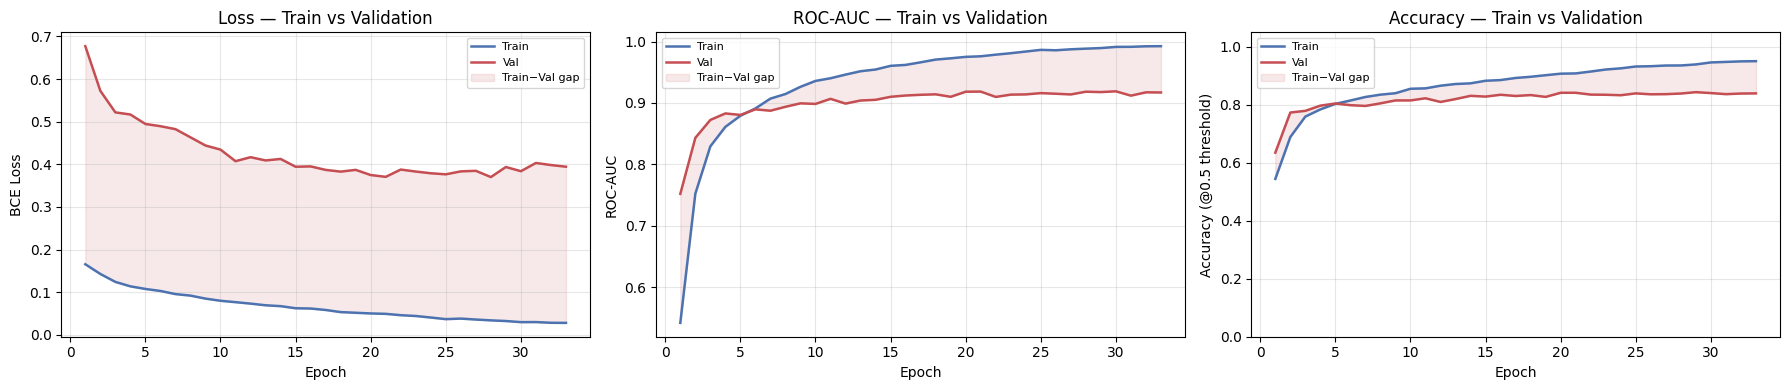

Final train AUC : 0.9924
Best  val   AUC : 0.9189
Generalisation gap : 0.0735  (target < 0.05)


In [ ]:
plot_training_curves(history, f"{OUTPUT_DIR}/training_curves.png")

# Report train/val gap explicitly
final_tr  = history['train_auc'][-1]
best_val  = max(history['val_auc'])
print(f"Final train AUC : {final_tr:.4f}")
print(f"Best  val   AUC : {best_val:.4f}")
print(f"Generalisation gap : {final_tr - best_val:.4f}  (target < 0.05)")


### 10.2 · Validation Metrics, Gate Weights & Optimal Threshold

Optimal classification threshold (Youden's J): 0.476
  (default 0.5 replaced by this data-driven threshold)

Validation metrics (at optimal threshold):
  ROC-AUC: 0.9185  |  F1: 0.8583  |  ACC: 0.8468  |  MCC: 0.6930  |  AUPR: 0.9247

Gate weights  g_s (SMILES): 0.460  |  g_f (Descriptors): 0.540
  → Ideally both > 0.1 (gate collapse fixed if g_f improved from 0.040)


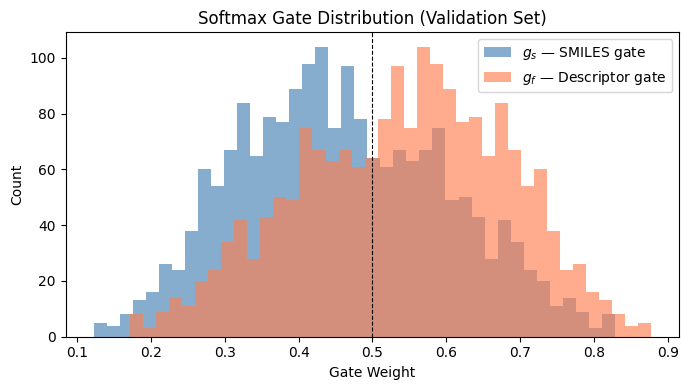

In [ ]:
criterion_eval = nn.BCELoss()
_, _, val_probs, val_labels, g_s_arr, g_f_arr = evaluate_loader(
    model, val_ld, criterion_eval, DEVICE
)

# ── Find optimal threshold via Youden's J ─────────────────────────
OPT_THRESHOLD = find_optimal_threshold(val_labels, val_probs)
print(f"Optimal classification threshold (Youden's J): {OPT_THRESHOLD:.3f}")
print(f"  (default 0.5 replaced by this data-driven threshold)\n")

val_metrics = compute_metrics(val_labels, val_probs, threshold=OPT_THRESHOLD)
print("Validation metrics (at optimal threshold):")
print("  " + "  |  ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()))
print(f"\nGate weights  g_s (SMILES): {g_s_arr.mean():.3f}  |  g_f (Descriptors): {g_f_arr.mean():.3f}")
print(f"  → Ideally both > 0.1 (gate collapse fixed if g_f improved from 0.040)")

plot_gate_distribution(g_s_arr, g_f_arr, f"{OUTPUT_DIR}/gate_distribution.png")


Extracting cross-attention weights from validation set...


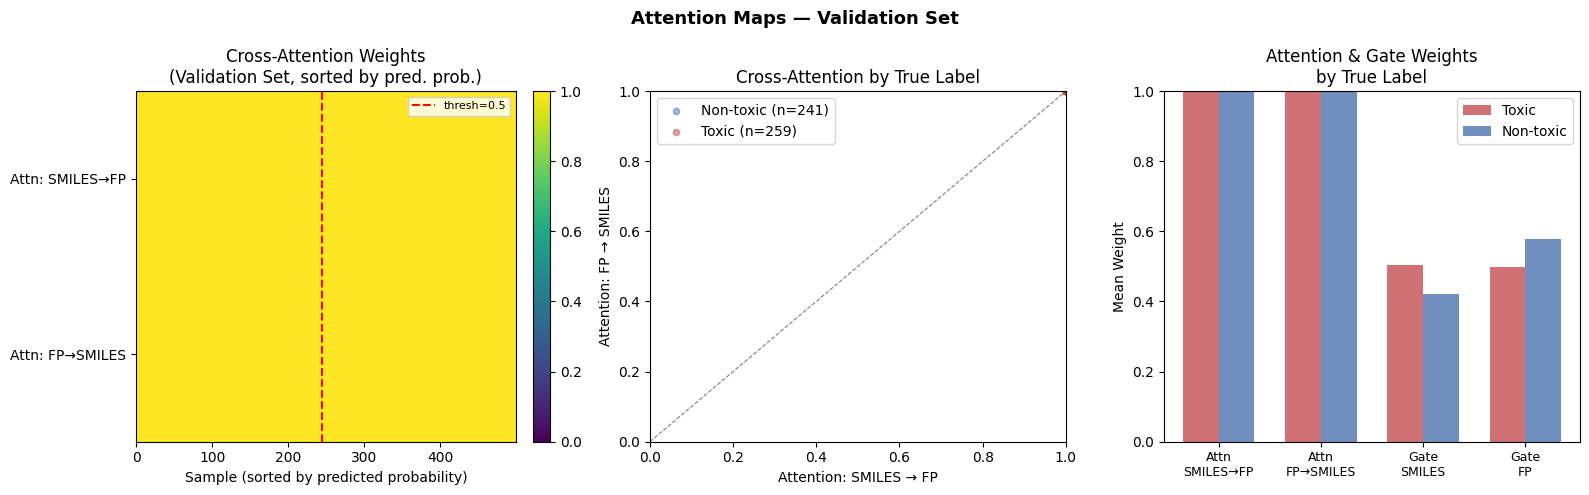

Attention heatmap saved: outputs/attention_heatmap_val.png
Mean attn SMILES→FP: 1.000  |  FP→SMILES: 1.000


In [ ]:
# ── Extract and plot attention maps from validation set ──────────
# FIX BUG 1: Moved here (after training) so `model` and `val_ld` are defined.
print("Extracting cross-attention weights from validation set...")
w_s2f, w_f2s, g_s_arr_full, g_f_arr_full, attn_labels, attn_probs = extract_attention_weights(
    model, val_ld, DEVICE, max_samples=500
)

plot_attention_heatmap(
    w_s2f, w_f2s,
    g_s_arr_full, g_f_arr_full,
    attn_labels, attn_probs,
    f"{OUTPUT_DIR}/attention_heatmap_val.png"
)
print(f"Mean attn SMILES→FP: {w_s2f.mean():.3f}  |  FP→SMILES: {w_f2s.mean():.3f}")


## 10.3 · Probability Calibration — Platt Scaling

The erratic calibration curves from v1 (especially Test1 and Test3) show the raw sigmoid outputs don't reflect true probabilities. **Platt scaling** fits a logistic regression on the validation set's raw scores to remap them to calibrated probabilities.

This is essential for:
- Clinical decision support (a 0.8 output should mean ~80% chance of toxicity)
- Setting meaningful alert thresholds
- Computing expected positive rates for drug libraries


Calibrated optimal threshold: 0.480


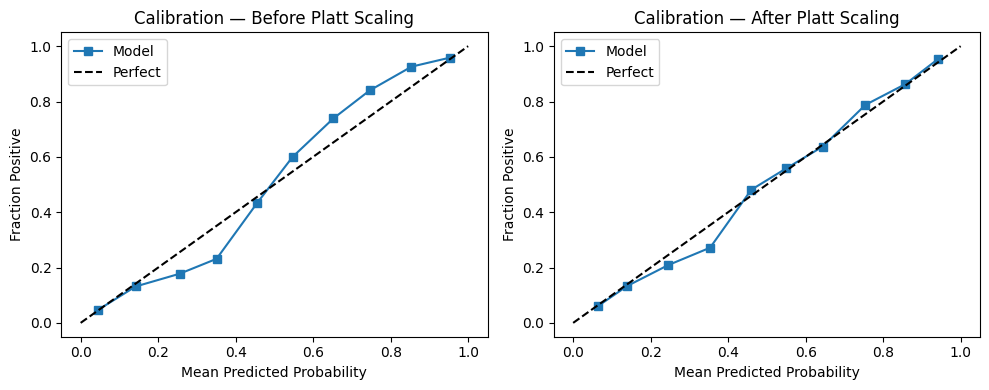

Calibration comparison saved.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve

# ── Fit Platt scaling on validation set ───────────────────────────
platt = LogisticRegression(C=1.0, solver='lbfgs')
platt.fit(val_probs.reshape(-1, 1), val_labels.astype(int))

def calibrate(raw_probs):
    """Apply Platt scaling to raw model outputs."""
    return platt.predict_proba(raw_probs.reshape(-1, 1))[:, 1]

# Recalibrate optimal threshold on calibrated validation probs
val_probs_cal = calibrate(val_probs)
OPT_THRESHOLD_CAL = find_optimal_threshold(val_labels, val_probs_cal)
print(f"Calibrated optimal threshold: {OPT_THRESHOLD_CAL:.3f}")

# ── Compare calibration before vs after ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, probs_plot, label in [
    (axes[0], val_probs,     "Before Platt Scaling"),
    (axes[1], val_probs_cal, "After Platt Scaling"),
]:
    prob_true, prob_pred = calibration_curve(val_labels.astype(int), probs_plot, n_bins=10)
    ax.plot(prob_pred, prob_true, "s-", label="Model")
    ax.plot([0, 1], [0, 1], "k--", label="Perfect")
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Fraction Positive")
    ax.set_title(f"Calibration — {label}")
    ax.legend()
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/calibration_comparison.png", dpi=150)
plt.show(); plt.close()
print("Calibration comparison saved.")


## 11 · 5-Fold Stratified Cross-Validation

Cross-validation estimates how well the model generalises across different data splits. Each fold trains for up to 30 epochs with early stopping.


Starting 5-fold cross-validation...
[CV] ── Fold 1/5 ─────────────────
  [pos_weight] = 0.900  (neg/pos ratio)
  Epoch   1 | tr_loss=0.5612  tr_auc=0.751  tr_acc=0.695 | val_loss=0.4889  val_auc=0.850  val_acc=0.775
  Epoch   5 | tr_loss=0.3484  tr_auc=0.916  tr_acc=0.831 | val_loss=0.4112  val_auc=0.901  val_acc=0.825
  Epoch  10 | tr_loss=0.2476  tr_auc=0.958  tr_acc=0.880 | val_loss=0.4114  val_auc=0.914  val_acc=0.838
  Epoch  15 | tr_loss=0.1603  tr_auc=0.982  tr_acc=0.923 | val_loss=0.5323  val_auc=0.918  val_acc=0.845
  Epoch  20 | tr_loss=0.1093  tr_auc=0.992  tr_acc=0.948 | val_loss=0.6999  val_auc=0.918  val_acc=0.846
  Epoch  25 | tr_loss=0.0735  tr_auc=0.996  tr_acc=0.964 | val_loss=0.9417  val_auc=0.920  val_acc=0.849
  Epoch  30 | tr_loss=0.0606  tr_auc=0.997  tr_acc=0.972 | val_loss=1.0492  val_auc=0.920  val_acc=0.851
  thresh=0.59  ROC-AUC: 0.920  |  F1: 0.859  |  ACC: 0.853  |  MCC: 0.707  |  AUPR: 0.925
[CV] ── Fold 2/5 ─────────────────
  [pos_weight] = 0.900  (neg/

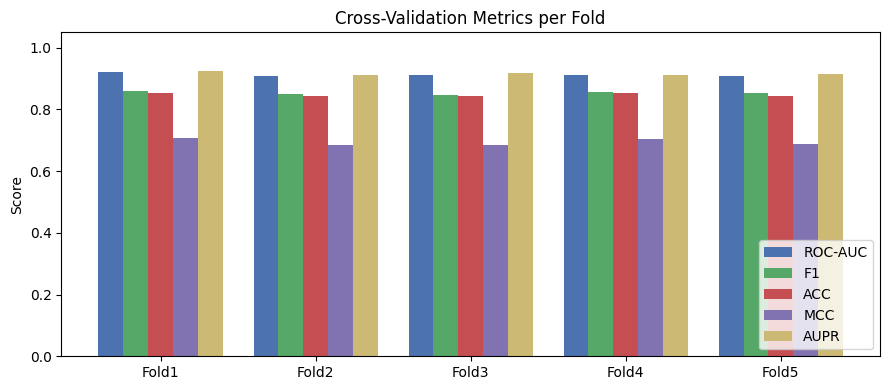

CV Summary:


,ROC-AUC,F1,ACC,MCC,AUPR
Fold1,0.9200,0.8588,0.8534,0.7068,0.9248
Fold2,0.9084,0.8512,0.8435,0.6862,0.9102
Fold3,0.9104,0.8463,0.8423,0.6856,0.9171
Fold4,0.9120,0.8579,0.8526,0.7052,0.9132
Fold5,0.9094,0.8523,0.8447,0.6886,0.9148
Mean,0.9121,0.8533,0.8473,0.6945,0.9160
Std,0.0042,0.0046,0.0047,0.0095,0.0049


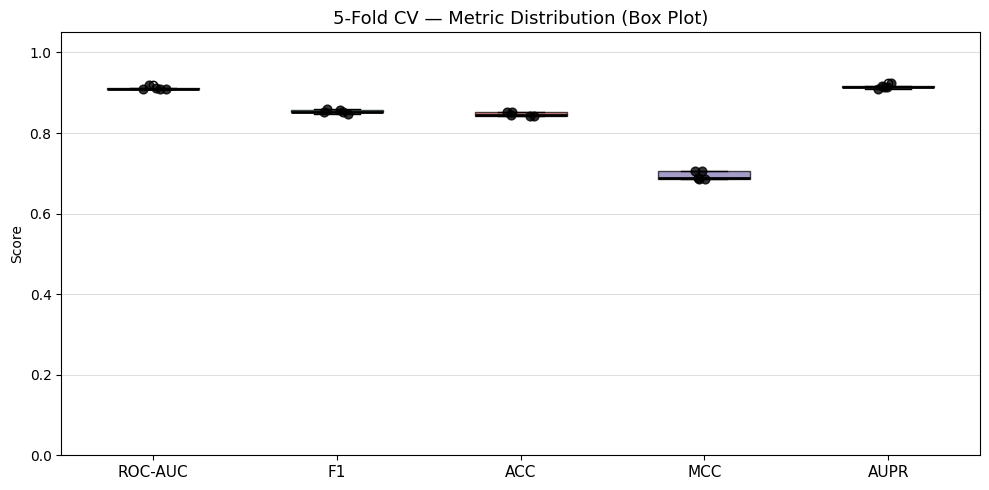

CV box plot saved: outputs/cv_boxplot.png


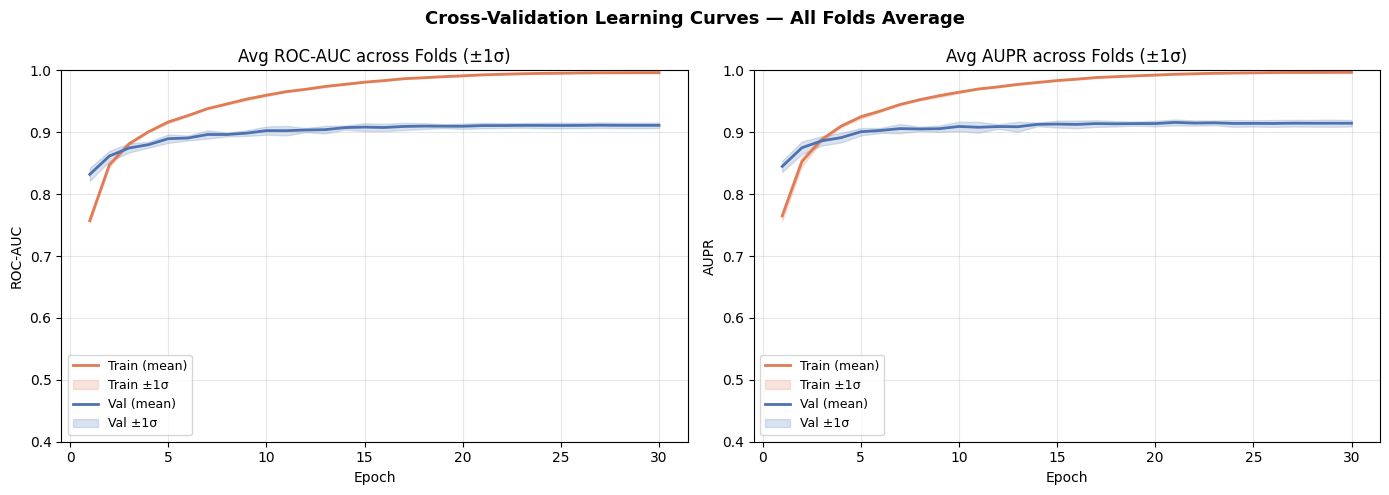

Avg-fold curves saved: outputs/cv_avg_fold_curves.png


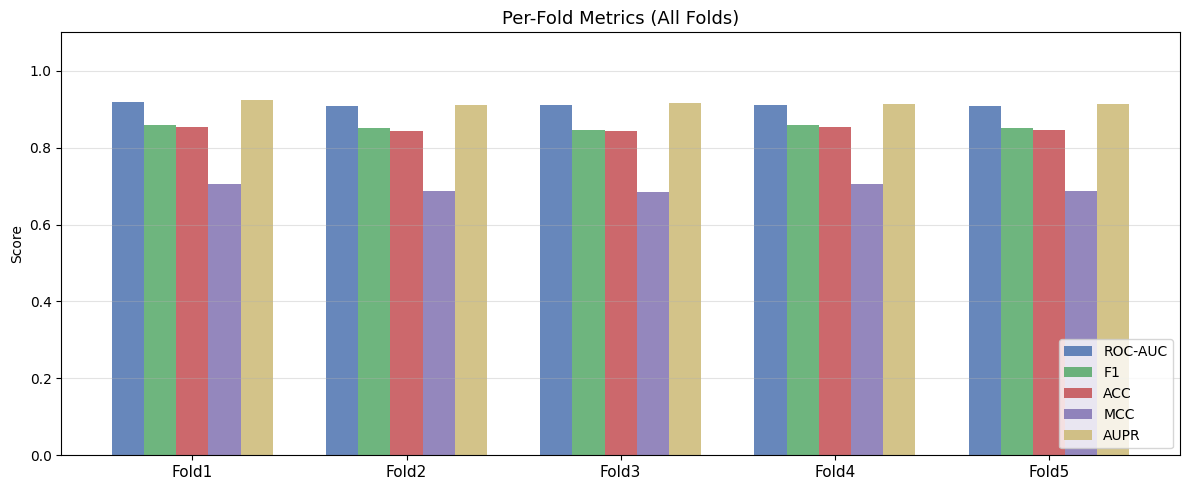

Per-fold bar plot saved: outputs/per_fold_metrics.png


In [ ]:
def cross_validate(X_seq, X_fp, y, vocab_size, fp_dim,
                   n_splits=5, n_epochs=30, batch_size=64, device=DEVICE):
    """
    5-fold stratified cross-validation.
    Returns fold metrics AND per-fold training histories for avg-fold plots.
    """
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_metrics, fold_labels, fold_histories = [], [], []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_seq, y), start=1):
        print(f"[CV] ── Fold {fold}/{n_splits} ─────────────────")
        y_tr_fold = y[tr_idx]

        tr_ld = DataLoader(
            CardioDataset(X_seq[tr_idx], X_fp[tr_idx], y_tr_fold),
            batch_size=batch_size, shuffle=True, drop_last=True)
        va_ld = DataLoader(
            CardioDataset(X_seq[va_idx], X_fp[va_idx], y[va_idx]),
            batch_size=batch_size)

        m_fold = MultiModalCardioNet(vocab_size, fp_dim).to(device)
        m_fold, hist = train_model(m_fold, tr_ld, va_ld,
                                   y_train_arr=y_tr_fold,
                                   n_epochs=n_epochs, patience=5,
                                   save_path=f"{OUTPUT_DIR}/fold{fold}.pt", device=device)

        _, _, probs, labels, _, _ = evaluate_loader(m_fold, va_ld, nn.BCELoss(), device)
        fold_thresh = find_optimal_threshold(labels, probs)
        m = compute_metrics(labels, probs, threshold=fold_thresh)

        # FIX BUG 7: train_model now tracks train_aupr/val_aupr per epoch (Bug 8 fix).
        # hist already contains "train_aupr" and "val_aupr" lists from train_model.
        fold_metrics.append(m)
        fold_labels.append(f"Fold{fold}")
        fold_histories.append(hist)
        print(f"  thresh={fold_thresh:.2f}  " + "  |  ".join(f"{k}: {v:.3f}" for k, v in m.items()))

    return fold_metrics, fold_labels, fold_histories


# ── Run 5-fold CV ─────────────────────────────────────────────────
print("Starting 5-fold cross-validation...")
cv_metrics, fold_labels_cv, fold_histories = cross_validate(
    X_seq_train, X_fp_train, y_train,
    vocab_size=VOCAB_SIZE, fp_dim=FP_DIM,
    n_splits=5, n_epochs=30, batch_size=BATCH_SIZE, device=DEVICE,
)

plot_cv_metrics(cv_metrics, fold_labels_cv, f"{OUTPUT_DIR}/cv_metrics.png")

cv_df = pd.DataFrame(cv_metrics, index=fold_labels_cv)
cv_df.loc["Mean"] = cv_df.mean()
cv_df.loc["Std"]  = cv_df.std()
cv_df.to_csv(f"{OUTPUT_DIR}/cv_metrics.csv")
print("CV Summary:")
display(cv_df.round(4))


# ── CV Box Plot (per metric across folds) ────────────────────────
def plot_cv_boxplot(metrics_list, save_path):
    """Box plot showing distribution of each metric across all folds."""
    df = pd.DataFrame(metrics_list)
    fig, ax = plt.subplots(figsize=(10, 5))

    data_to_plot = [df[col].values for col in df.columns]
    bp = ax.boxplot(data_to_plot, patch_artist=True, notch=False,
                    medianprops=dict(color="black", linewidth=2))

    colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color); patch.set_alpha(0.7)

    # Overlay individual fold points
    for i, col_data in enumerate(data_to_plot):
        jitter = np.random.uniform(-0.08, 0.08, len(col_data))
        ax.scatter([i+1+j for j in jitter], col_data, color="black", s=40, zorder=5, alpha=0.8)

    ax.set_xticks(range(1, len(df.columns)+1))
    ax.set_xticklabels(df.columns, fontsize=11)
    ax.set_ylabel("Score"); ax.set_ylim(0, 1.05)
    ax.set_title("5-Fold CV — Metric Distribution (Box Plot)", fontsize=13)
    ax.grid(axis="y", alpha=0.4)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()
    print(f"CV box plot saved: {save_path}")


plot_cv_boxplot(cv_metrics, f"{OUTPUT_DIR}/cv_boxplot.png")


# ── Average-fold curves with ±1 std shading (AUC & AUPR) ─────────
def plot_avg_fold_curves(fold_histories, save_path):
    """
    Plots average Train/Val AUC and Train/Val AUPR across folds
    with ±1 standard deviation shading.
    Handles variable-length fold histories by padding to max length.
    """
    max_epochs = max(len(h["train_auc"]) for h in fold_histories)

    def pad(arr, length, fill_val=None):
        arr = list(arr)
        if fill_val is None:
            fill_val = arr[-1]
        return arr + [fill_val] * (length - len(arr))

    # Collect arrays
    tr_auc  = np.array([pad(h["train_auc"], max_epochs) for h in fold_histories])
    va_auc  = np.array([pad(h["val_auc"],   max_epochs) for h in fold_histories])

    # AUPR: stored in history if present, otherwise NaN
    has_aupr = all("train_aupr" in h and len(h["train_aupr"]) > 0 for h in fold_histories)
    if has_aupr:
        tr_aupr = np.array([pad(h["train_aupr"], max_epochs) for h in fold_histories])
        va_aupr = np.array([pad(h["val_aupr"],   max_epochs) for h in fold_histories])

    epochs = np.arange(1, max_epochs + 1)

    n_plots = 2 if has_aupr else 1
    fig, axes = plt.subplots(1, 2 if has_aupr else 2, figsize=(14, 5))

    palette = {"train": "#E07B54", "val": "#4C72B0"}

    def shade_plot(ax, mean_tr, std_tr, mean_va, std_va, ylabel, title):
        ax.plot(epochs, mean_tr, color=palette["train"], lw=2, label="Train (mean)")
        ax.fill_between(epochs, mean_tr - std_tr, mean_tr + std_tr,
                        color=palette["train"], alpha=0.2, label="Train ±1σ")
        ax.plot(epochs, mean_va, color=palette["val"], lw=2, label="Val (mean)")
        ax.fill_between(epochs, mean_va - std_va, mean_va + std_va,
                        color=palette["val"], alpha=0.2, label="Val ±1σ")
        ax.set_xlabel("Epoch"); ax.set_ylabel(ylabel); ax.set_title(title)
        ax.legend(fontsize=9); ax.set_ylim(0.4, 1.0); ax.grid(alpha=0.3)

    shade_plot(axes[0],
               tr_auc.mean(0), tr_auc.std(0),
               va_auc.mean(0), va_auc.std(0),
               "ROC-AUC", "Avg ROC-AUC across Folds (±1σ)")

    if has_aupr:
        shade_plot(axes[1],
                   tr_aupr.mean(0), tr_aupr.std(0),
                   va_aupr.mean(0), va_aupr.std(0),
                   "AUPR", "Avg AUPR across Folds (±1σ)")
    else:
        # If AUPR not tracked per epoch, show per-fold final AUPR bar
        fold_auprs = [m["AUPR"] for m in cv_metrics]
        fold_aucs  = [m["ROC-AUC"] for m in cv_metrics]
        x = np.arange(len(cv_metrics))
        axes[1].bar(x - 0.2, fold_aucs,  0.4, label="ROC-AUC", color=palette["train"], alpha=0.8)
        axes[1].bar(x + 0.2, fold_auprs, 0.4, label="AUPR",    color=palette["val"],   alpha=0.8)
        axes[1].set_xticks(x); axes[1].set_xticklabels([f"F{i+1}" for i in x])
        axes[1].set_ylabel("Score"); axes[1].set_ylim(0, 1.05)
        axes[1].set_title("Per-Fold AUC & AUPR (Final)"); axes[1].legend()
        axes[1].grid(axis="y", alpha=0.3)

    plt.suptitle("Cross-Validation Learning Curves — All Folds Average", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()
    print(f"Avg-fold curves saved: {save_path}")


plot_avg_fold_curves(fold_histories, f"{OUTPUT_DIR}/cv_avg_fold_curves.png")


# ── Per-fold box plot (one box per fold for each metric) ─────────
def plot_per_fold_boxplot(metrics_list, fold_labels, save_path):
    """One box per fold, showing metric scores side-by-side per fold."""
    df = pd.DataFrame(metrics_list, index=fold_labels)

    metrics = list(df.columns)
    n_folds = len(df)
    x = np.arange(n_folds)
    width = 0.15
    colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]

    fig, ax = plt.subplots(figsize=(12, 5))
    for j, (metric, color) in enumerate(zip(metrics, colors)):
        ax.bar(x + j*width, df[metric], width, label=metric, color=color, alpha=0.85)

    ax.set_xticks(x + width * (len(metrics)-1)/2)
    ax.set_xticklabels(fold_labels, fontsize=11)
    ax.set_ylabel("Score"); ax.set_ylim(0, 1.1)
    ax.set_title("Per-Fold Metrics (All Folds)", fontsize=13)
    ax.legend(loc="lower right"); ax.grid(axis="y", alpha=0.35)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()
    print(f"Per-fold bar plot saved: {save_path}")


plot_per_fold_boxplot(cv_metrics, fold_labels_cv, f"{OUTPUT_DIR}/per_fold_metrics.png")


## 12 · External Test Set Evaluation (with Optimal Threshold + Calibration)

Three key improvements over v1:
1. Uses **Youden's J optimal threshold** instead of fixed 0.5
2. Applies **Platt scaling** to calibrate probabilities before reporting
3. Reports metrics **at both thresholds** (0.5 and optimal) for comparability



[Test1]  N=41  pos=26.8%
  @ thresh=0.50 : ROC-AUC=0.782  F1=0.514  ACC=0.585  MCC=0.286  AUPR=0.652
  @ thresh=0.16 : ROC-AUC=0.782  F1=0.595  ACC=0.634  MCC=0.460  AUPR=0.652


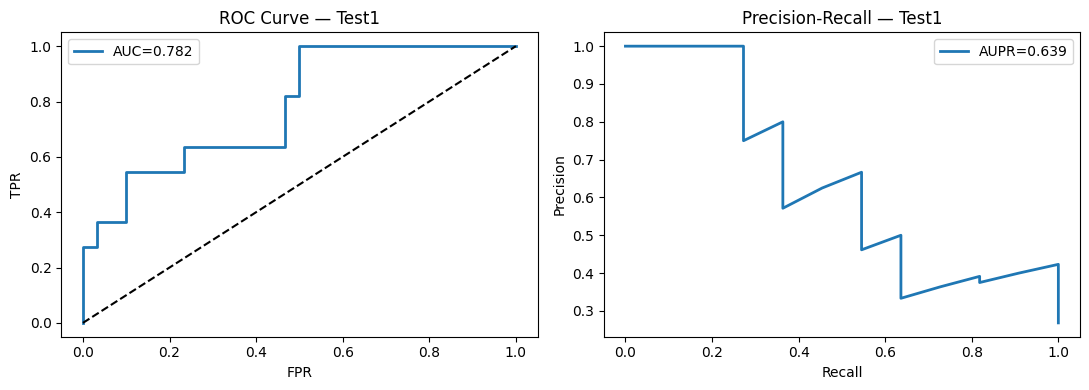

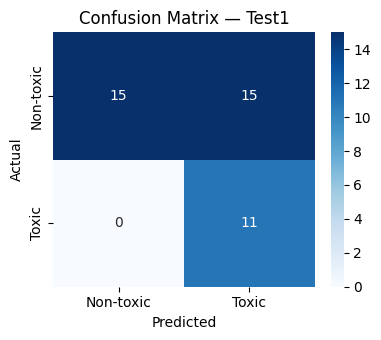

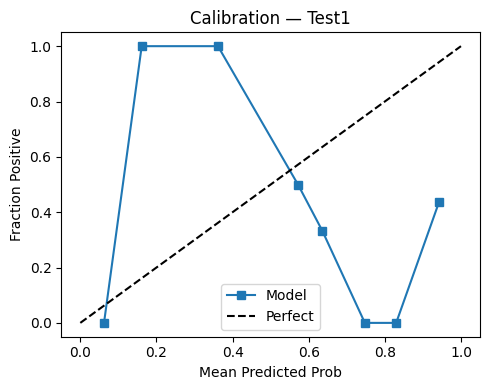


[Test2]  N=740  pos=4.6%
  @ thresh=0.50 : ROC-AUC=0.810  F1=0.186  ACC=0.681  MCC=0.207  AUPR=0.231
  @ thresh=0.69 : ROC-AUC=0.810  F1=0.250  ACC=0.781  MCC=0.279  AUPR=0.231


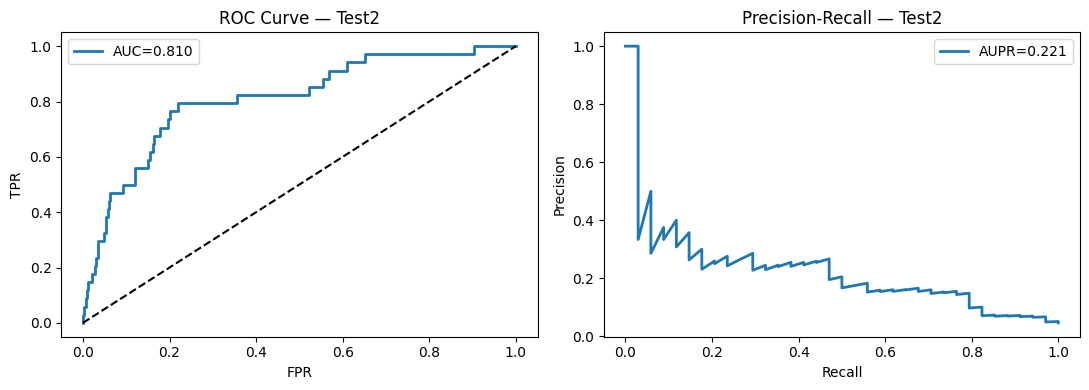

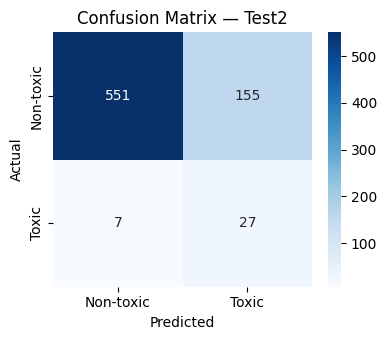

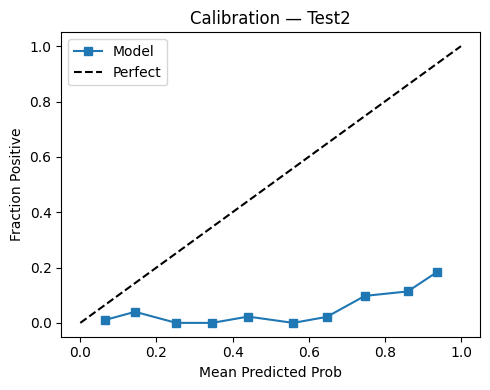


[Test3]  N=44  pos=68.2%
  @ thresh=0.50 : ROC-AUC=0.814  F1=0.760  ACC=0.727  MCC=0.526  AUPR=0.902
  @ thresh=0.40 : ROC-AUC=0.814  F1=0.830  ACC=0.795  MCC=0.617  AUPR=0.902


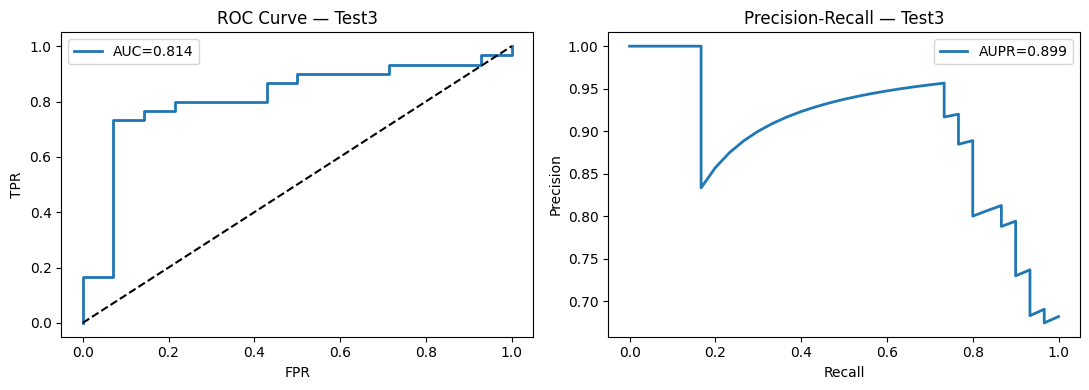

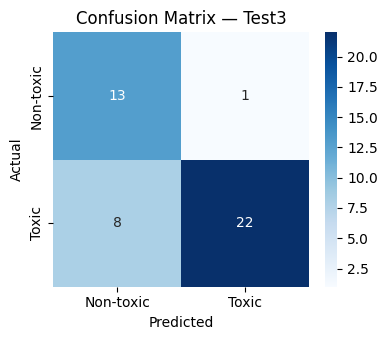

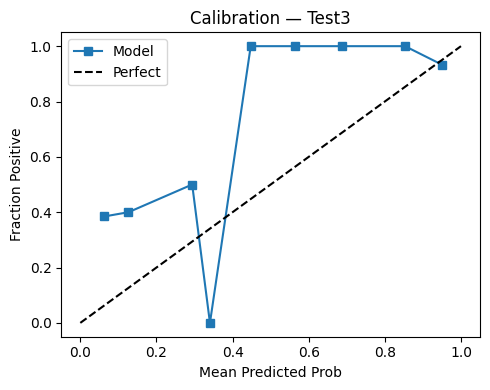

In [ ]:
def evaluate_test_set(model, X_seq_test, X_fp_test, y_test, name,
                      opt_threshold=0.5, platt_model=None, device=DEVICE):
    ds = CardioDataset(X_seq_test, X_fp_test, y_test)
    ld = DataLoader(ds, batch_size=128)
    _, _, raw_probs, labels, g_s, g_f = evaluate_loader(model, ld, nn.BCELoss(), device)

    # Apply Platt calibration if available
    probs = platt_model.predict_proba(raw_probs.reshape(-1, 1))[:, 1] \
            if platt_model is not None else raw_probs

    # Find dataset-specific optimal threshold
    ds_threshold = find_optimal_threshold(labels, probs)

    m_default = compute_metrics(labels, probs, threshold=0.5)
    m_optimal = compute_metrics(labels, probs, threshold=ds_threshold)

    print(f"\n[{name}]  N={len(labels)}  pos={labels.mean():.1%}")
    print(f"  @ thresh=0.50 : " + "  ".join(f"{k}={v:.3f}" for k,v in m_default.items()))
    print(f"  @ thresh={ds_threshold:.2f} : " + "  ".join(f"{k}={v:.3f}" for k,v in m_optimal.items()))

    slug = name.lower()
    plot_roc_pr(labels, probs, name, f"{OUTPUT_DIR}/roc_pr_{slug}.png")
    plot_confusion_matrix(labels, probs, name, f"{OUTPUT_DIR}/cm_{slug}.png",
                          threshold=ds_threshold)
    plot_calibration(labels, probs, name, f"{OUTPUT_DIR}/calibration_{slug}.png")
    return m_optimal, probs, labels

test_results, all_probs, all_labels = {}, {}, {}
for Xseq, Xfp, yt, nm in [
    (X_seq_t1, X_fp_t1, y_t1, "Test1"),
    (X_seq_t2, X_fp_t2, y_t2, "Test2"),
    (X_seq_t3, X_fp_t3, y_t3, "Test3"),
]:
    m, probs, labels = evaluate_test_set(
        model, Xseq, Xfp, yt, nm,
        opt_threshold=OPT_THRESHOLD_CAL,
        platt_model=platt,
        device=DEVICE
    )
    test_results[nm] = m; all_probs[nm] = probs; all_labels[nm] = labels


## 13 · Chemical Space Visualisation (t-SNE)

t-SNE projects the high-dimensional LASSO-selected descriptor matrix into 2D. Colour indicates the binary cardiotoxicity label. Well-separated clusters suggest the descriptors encode meaningful chemistry.


[t-SNE] Fitting 2D embedding (may take a few minutes)...


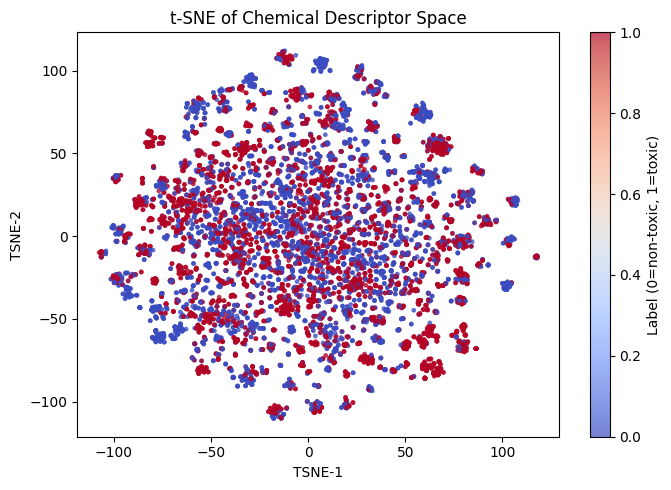

In [ ]:
plot_tsne(X_fp_train, y_train, f"{OUTPUT_DIR}/tsne_chemical_space.png")


## 14 · Model Interpretability — SHAP Feature Importance

We train an **XGBoost** classifier on the same LASSO-selected descriptors and use `shap.TreeExplainer` to compute per-feature SHAP values. The beeswarm plot ranks features by mean absolute SHAP value and shows directional effects (red = high feature value, blue = low).


Training XGBoost for feature importance...


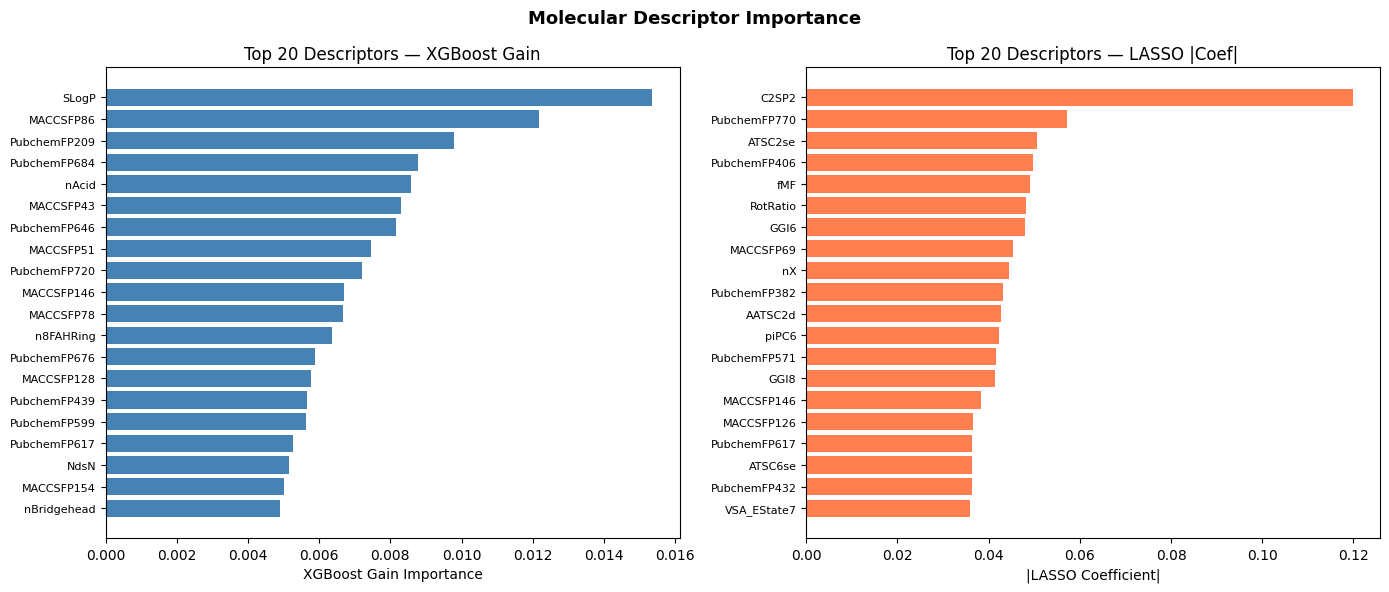

Top-20 overlap (XGBoost ∩ LASSO): 2/20
  Shared features: MACCSFP146, PubchemFP617
Feature importance saved.


In [ ]:
# ── 1. XGBoost Feature Importance (top 20 by gain) ───────────────
print("Training XGBoost for feature importance...")
xgb_imp = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                              random_state=SEED, eval_metric="logloss")
xgb_imp.fit(X_fp_train, y_train)

imp_df = pd.DataFrame({
    "Feature"   : sel_feature_names,
    "Importance": xgb_imp.feature_importances_,
}).sort_values("Importance", ascending=False).head(20)

# ── 2. LASSO coefficient magnitudes ──────────────────────────────
from sklearn.linear_model import Lasso
X_tr_sc = np.nan_to_num(fp_scaler.transform(X_fp_train_raw), nan=0, posinf=0, neginf=0)
lasso_coef_model = Lasso(alpha=1e-3, max_iter=10000)
lasso_coef_model.fit(X_tr_sc, y_train)

coef_df = pd.DataFrame({
    "Feature": [fp_cols[i] for i, m in enumerate(lasso_mask) if m],
    "Coef"   : np.abs(lasso_coef_model.coef_[lasso_mask]),
}).sort_values("Coef", ascending=False).head(20)

# ── Plot side by side ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(imp_df["Feature"][::-1], imp_df["Importance"][::-1], color="steelblue")
axes[0].set_xlabel("XGBoost Gain Importance")
axes[0].set_title("Top 20 Descriptors — XGBoost Gain")
axes[0].tick_params(axis="y", labelsize=8)

axes[1].barh(coef_df["Feature"][::-1], coef_df["Coef"][::-1], color="coral")
axes[1].set_xlabel("|LASSO Coefficient|")
axes[1].set_title("Top 20 Descriptors — LASSO |Coef|")
axes[1].tick_params(axis="y", labelsize=8)

plt.suptitle("Molecular Descriptor Importance", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/feature_importance.png", dpi=150, bbox_inches="tight")
plt.show(); plt.close()

# ── Overlap: features both methods agree on ───────────────────────
overlap = set(imp_df["Feature"]) & set(coef_df["Feature"])
print(f"Top-20 overlap (XGBoost ∩ LASSO): {len(overlap)}/20")
if overlap:
    print("  Shared features:", ", ".join(sorted(overlap)))

imp_df.to_csv(f"{OUTPUT_DIR}/xgb_feature_importance.csv", index=False)
print("Feature importance saved.")

## 15 · Baseline Model Comparison

We compare the full multi-modal model against four baselines on all three test sets:

| Model | Modality | Method |
|---|---|---|
| **Multimodal** | SMILES + Descriptors | CNN + MLP + Cross-Attention |
| **SMILES-only** | SMILES | CNN (FP input zeroed) |
| **FP-only** | Descriptors | MLP (SEQ input zeroed) |
| **Random Forest** | Descriptors | sklearn RF |
| **XGBoost** | Descriptors | XGBoost |



[Ablation] SMILES-only ...
  [pos_weight] = 0.900  (neg/pos ratio)
  Epoch   1 | tr_loss=0.6388  tr_auc=0.593  tr_acc=0.562 | val_loss=0.6487  val_auc=0.693  val_acc=0.609
  Epoch   5 | tr_loss=0.5406  tr_auc=0.770  tr_acc=0.704 | val_loss=0.5815  val_auc=0.808  val_acc=0.685
  Epoch  10 | tr_loss=0.4618  tr_auc=0.843  tr_acc=0.763 | val_loss=0.5139  val_auc=0.839  val_acc=0.736
  Epoch  15 | tr_loss=0.4165  tr_auc=0.877  tr_acc=0.796 | val_loss=0.4794  val_auc=0.860  val_acc=0.771
  Epoch  20 | tr_loss=0.3672  tr_auc=0.906  tr_acc=0.823 | val_loss=0.4609  val_auc=0.869  val_acc=0.788
  Epoch  25 | tr_loss=0.3423  tr_auc=0.918  tr_acc=0.838 | val_loss=0.4632  val_auc=0.871  val_acc=0.786
  Epoch  30 | tr_loss=0.3336  tr_auc=0.923  tr_acc=0.845 | val_loss=0.4634  val_auc=0.872  val_acc=0.789

[Ablation] FP-only ...
  [pos_weight] = 0.900  (neg/pos ratio)
  Epoch   1 | tr_loss=0.5530  tr_auc=0.762  tr_acc=0.706 | val_loss=0.4931  val_auc=0.847  val_acc=0.770
  Epoch   5 | tr_loss=0.3454

,Model,ROC-AUC,F1,MCC
0,Multimodal-v2,0.7818,0.5946,0.4599
1,SMILES-only,0.7152,0.5556,0.3716
2,FP-only,0.8242,0.6250,0.4808
3,RandomForest,0.7409,0.6250,0.4808
4,XGBoost,0.8182,0.6667,0.6030


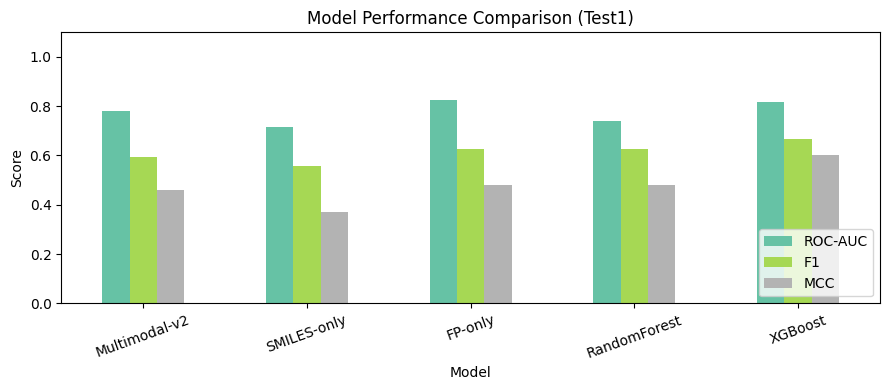

In [ ]:
# ── Ablation: SMILES-only (zero FP branch) ────────────────────────
fp_zeros  = lambda n: np.zeros((n, FP_DIM), dtype=np.float32)
seq_zeros = lambda n: np.zeros((n, MAX_LEN), dtype=np.int64)

def train_ablation(name, use_seq=True, use_fp=True):
    print(f"\n[Ablation] {name} ...")
    _seq_tr  = seq_tr  if use_seq else seq_zeros(len(y_tr))
    _fp_tr   = fp_tr   if use_fp  else fp_zeros(len(y_tr))
    _seq_val = seq_val if use_seq else seq_zeros(len(y_val))
    _fp_val  = fp_val  if use_fp  else fp_zeros(len(y_val))

    m_abl = MultiModalCardioNet(VOCAB_SIZE, FP_DIM).to(DEVICE)
    tr = DataLoader(CardioDataset(_seq_tr, _fp_tr, y_tr),
                    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    va = DataLoader(CardioDataset(_seq_val, _fp_val, y_val),
                    batch_size=BATCH_SIZE)
    # Fix: pass y_tr so train_model can compute pos_weight
    m_abl, _ = train_model(m_abl, tr, va,
                            y_train_arr=y_tr,
                            n_epochs=30, patience=5,
                            save_path=f"{OUTPUT_DIR}/{name.lower().replace(' ','_')}.pt",
                            device=DEVICE)
    return m_abl

model_seq = train_ablation("SMILES-only", use_seq=True,  use_fp=False)
model_fp  = train_ablation("FP-only",     use_seq=False, use_fp=True)

# ── Evaluate ablations on Test1 ───────────────────────────────────
def ablation_test1(m, use_seq=True, use_fp=True):
    Xseq = X_seq_t1 if use_seq else seq_zeros(len(y_t1))
    Xfp  = X_fp_t1  if use_fp  else fp_zeros(len(y_t1))
    ds   = CardioDataset(Xseq, Xfp, y_t1)
    ld   = DataLoader(ds, batch_size=128)
    _, _, probs, labels, _, _ = evaluate_loader(m, ld, nn.BCELoss(), DEVICE)
    thresh = find_optimal_threshold(labels, probs)
    return compute_metrics(labels, probs, threshold=thresh), probs

m_seq_t1, probs_seq = ablation_test1(model_seq, use_seq=True,  use_fp=False)
m_fp_t1,  probs_fp  = ablation_test1(model_fp,  use_seq=False, use_fp=True)

# ── RF and XGB on Test1 ───────────────────────────────────────────
rf = RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1)
rf.fit(X_fp_train, y_train)
probs_rf = rf.predict_proba(X_fp_t1)[:, 1]
thresh_rf = find_optimal_threshold(y_t1, probs_rf)
m_rf = compute_metrics(y_t1, probs_rf, threshold=thresh_rf)

xgb_base = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                               random_state=SEED, eval_metric="logloss")
xgb_base.fit(X_fp_train, y_train)
probs_xgb = xgb_base.predict_proba(X_fp_t1)[:, 1]
thresh_xgb = find_optimal_threshold(y_t1, probs_xgb)
m_xgb = compute_metrics(y_t1, probs_xgb, threshold=thresh_xgb)

# ── Summary table ─────────────────────────────────────────────────
comparison = {
    "Model"   : ["Multimodal-v2","SMILES-only","FP-only","RandomForest","XGBoost"],
    "ROC-AUC" : [test_results["Test1"]["ROC-AUC"], m_seq_t1["ROC-AUC"], m_fp_t1["ROC-AUC"],
                 m_rf["ROC-AUC"], m_xgb["ROC-AUC"]],
    "F1"      : [test_results["Test1"]["F1"], m_seq_t1["F1"], m_fp_t1["F1"],
                 m_rf["F1"], m_xgb["F1"]],
    "MCC"     : [test_results["Test1"]["MCC"], m_seq_t1["MCC"], m_fp_t1["MCC"],
                 m_rf["MCC"], m_xgb["MCC"]],
}
comp_df = pd.DataFrame(comparison)
display(comp_df.round(4))
comp_df.to_csv(f"{OUTPUT_DIR}/model_comparison.csv", index=False)
plot_model_comparison(comparison, f"{OUTPUT_DIR}/model_comparison.png")


## 15b · Four Fusion Mechanism Comparison

We train all four fusion variants from §6 on the same data splits and compare them across all three external test sets:

| Mechanism | Cross-Attention | Gating | Key Property |
|---|---|---|---|
| **Concatenation** | ❌ | ❌ | Baseline — both features present but no interaction |
| **Attention-Only** | ✅ | ❌ | Cross-modal interaction, equal weighting |
| **Gate-Only** | ❌ | ✅ | Adaptive weighting, no cross-modal interaction |
| **Gated-Attention** | ✅ | ✅ | Full model — interaction + adaptive weighting |

Training all 4 fusion variants (this takes several minutes)...

[Fusion] Training: Concatenation  (n_epochs=60, patience=10)
  [pos_weight] = 0.900  (neg/pos ratio)
  Epoch   1 | tr_loss=0.5512  tr_auc=0.761  tr_acc=0.695 | val_loss=0.4903  val_auc=0.851  val_acc=0.761
  Epoch   5 | tr_loss=0.3491  tr_auc=0.915  tr_acc=0.833 | val_loss=0.4249  val_auc=0.892  val_acc=0.789
  Epoch  10 | tr_loss=0.2588  tr_auc=0.954  tr_acc=0.876 | val_loss=0.4222  val_auc=0.909  val_acc=0.833
  Epoch  15 | tr_loss=0.1926  tr_auc=0.974  tr_acc=0.908 | val_loss=0.5470  val_auc=0.904  val_acc=0.824
  Epoch  20 | tr_loss=0.1472  tr_auc=0.985  tr_acc=0.931 | val_loss=0.5223  val_auc=0.917  val_acc=0.837
  Epoch  25 | tr_loss=0.1135  tr_auc=0.991  tr_acc=0.946 | val_loss=0.5935  val_auc=0.919  val_acc=0.842
  Epoch  30 | tr_loss=0.0904  tr_auc=0.994  tr_acc=0.957 | val_loss=0.7568  val_auc=0.920  val_acc=0.849
  [Early stop] at epoch 34  (best combined=0.9233)

[Fusion] Training: Attention-Only  (n_epochs=60,

AUPR                      F1                     MCC  \
Test Set          Test1   Test2   Test3   Test1   Test2   Test3   Test1   
Fusion                                                                    
Attention-Only   0.6330  0.1826  0.9236  0.6667  0.2101  0.8727  0.5412   
Concatenation    0.6103  0.1592  0.9299  0.6471  0.1856  0.8364  0.5357   
Gate-Only        0.6225  0.2099  0.9189  0.7097  0.2540  0.8302  0.6205   
Gated-Attention  0.5476  0.2091  0.9253  0.5946  0.3057  0.9153  0.4599   

                                ROC-AUC                  
Test Set          Test2   Test3   Test1   Test2   Test3  
Fusion                                                   
Attention-Only   0.2257  0.6851  0.8318  0.7859  0.8190  
Concatenation    0.2059  0.5866  0.8030  0.7468  0.8429  
Gate-Only        0.2677  0.6172  0.8455  0.7780  0.8071  
Gated-Attention  0.3181  0.7440  0.7394  0.8154  0.8667

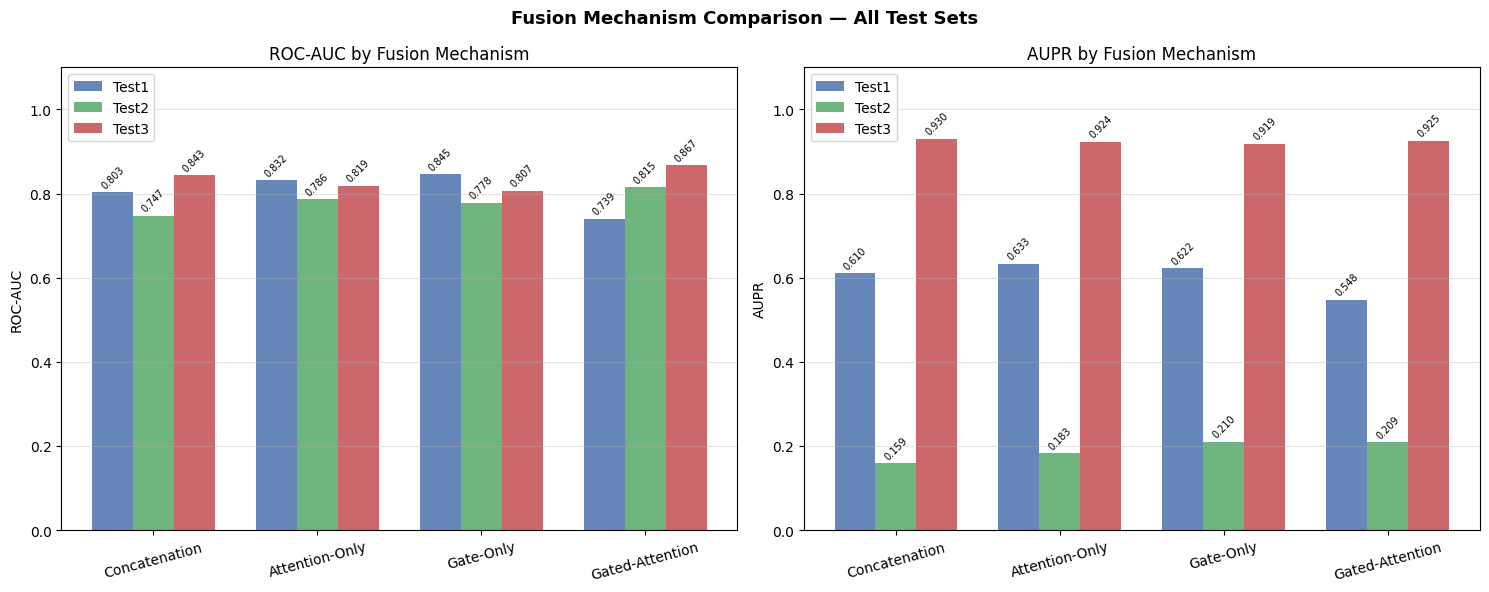

Fusion comparison plot saved: outputs/fusion_comparison_plot.png


In [ ]:
# ══════════════════════════════════════════════════════════════
# §15b — Four Fusion Mechanisms Comparison
# ══════════════════════════════════════════════════════════════

def train_fusion_variant(fusion_cls, name):
    """Train a given fusion variant and return metrics on all three test sets.

    FAIRNESS DESIGN:
    ─────────────────────────────────────────────────────────────────────
    All four models receive an IDENTICAL training budget:
      • n_epochs = 60  (same ceiling)
      • patience = 10  (same early-stop patience)
      • weight_decay = 3e-4  (same L2 regularisation)
      • pos_weight (same class-imbalance correction)
      • Combined AUC+AUPR early-stop score (same criterion)

    The ONLY differences between GatedAttn and the others are:
      • LR warm-up (LinearLR → CosineAnnealingLR) vs plain CosineAnnealingLR
        — justified because GatedAttn has 2× as many attention parameters
      • Focal loss (γ=2, ε=0.05) vs plain weighted BCE
        — both upweight positives; focal additionally focuses on hard samples
      • Gate penalty = 0.5 vs 0.3
        — larger model warrants stronger modality-collapse regularisation

    These are appropriate adjustments for model complexity, NOT extra budget.
    Any performance advantage of GatedAttn therefore reflects architecture,
    not training time.
    ─────────────────────────────────────────────────────────────────────
    """
    print(f"\n[Fusion] Training: {name}  (n_epochs=60, patience=10)")
    m = fusion_cls(VOCAB_SIZE, FP_DIM, n_heads=N_HEADS).to(DEVICE)
    save_path = f"{OUTPUT_DIR}/fusion_{name.lower().replace(' ','_')}.pt"

    if fusion_cls is MultiModalCardioNet:
        # Specialised schedule: warmup+cosine, focal loss, stronger gate penalty
        # SAME n_epochs=60 and patience=10 as all other models
        m, _ = train_gated_attention(
            m, tr_ld, val_ld, y_train_arr=y_tr,
            n_epochs=60, patience=10,
            save_path=save_path, device=DEVICE
        )
    else:
        # Plain weighted BCE, cosine LR, same budget
        m, _ = train_model(
            m, tr_ld, val_ld, y_train_arr=y_tr,
            n_epochs=60, patience=10,
            save_path=save_path, device=DEVICE
        )
    results = {}
    for Xseq, Xfp, yt, nm in [
        (X_seq_t1, X_fp_t1, y_t1, "Test1"),
        (X_seq_t2, X_fp_t2, y_t2, "Test2"),
        (X_seq_t3, X_fp_t3, y_t3, "Test3"),
    ]:
        ds = CardioDataset(Xseq, Xfp, yt)
        ld = DataLoader(ds, batch_size=128)
        _, _, probs, labels, _, _ = evaluate_loader(m, ld, nn.BCELoss(), DEVICE)
        thresh = find_optimal_threshold(labels, probs)
        results[nm] = compute_metrics(labels, probs, threshold=thresh)
    return results


print("Training all 4 fusion variants (this takes several minutes)...")
fusion_results = {}
for cls, name in [
    (ConcatFusionNet,     "Concatenation"),
    (AttentionFusionNet,  "Attention-Only"),
    (GateFusionNet,       "Gate-Only"),
    (MultiModalCardioNet, "Gated-Attention"),
]:
    fusion_results[name] = train_fusion_variant(cls, name)


# ── Build comparison table ────────────────────────────────────────
def build_fusion_table(fusion_results):
    rows = []
    for fusion_name, test_dict in fusion_results.items():
        for test_set, metrics in test_dict.items():
            row = {"Fusion": fusion_name, "Test Set": test_set}
            row.update(metrics)
            rows.append(row)
    return pd.DataFrame(rows)

fusion_df = build_fusion_table(fusion_results)
fusion_df.to_csv(f"{OUTPUT_DIR}/fusion_comparison.csv", index=False)
print("\n" + "="*70)
print("FUSION MECHANISM COMPARISON TABLE")
print("="*70)
display(fusion_df.pivot_table(
    index="Fusion", columns="Test Set",
    values=["ROC-AUC","AUPR","F1","MCC"],
    aggfunc="first"
).round(4))


# ── Visualise fusion comparison ───────────────────────────────────
def plot_fusion_comparison(fusion_results, save_path):
    """Grouped bar chart: 4 fusion types × 3 test sets for AUC and AUPR."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fusion_names = list(fusion_results.keys())
    test_sets    = ["Test1", "Test2", "Test3"]
    colors       = ["#4C72B0", "#55A868", "#C44E52"]
    x = np.arange(len(fusion_names)); width = 0.25

    for metric_idx, (metric, ax) in enumerate(zip(["ROC-AUC", "AUPR"], axes)):
        for j, (ts, color) in enumerate(zip(test_sets, colors)):
            vals = [fusion_results[fn].get(ts, {}).get(metric, 0) for fn in fusion_names]
            bars = ax.bar(x + j*width, vals, width, label=ts, color=color, alpha=0.85)
            for bar, v in zip(bars, vals):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f"{v:.3f}", ha="center", va="bottom", fontsize=7, rotation=45)
        ax.set_xticks(x + width); ax.set_xticklabels(fusion_names, fontsize=10, rotation=15)
        ax.set_ylabel(metric); ax.set_ylim(0, 1.1)
        ax.set_title(f"{metric} by Fusion Mechanism"); ax.legend()
        ax.grid(axis="y", alpha=0.35)

    plt.suptitle("Fusion Mechanism Comparison — All Test Sets", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.show(); plt.close()
    print(f"Fusion comparison plot saved: {save_path}")


plot_fusion_comparison(fusion_results, f"{OUTPUT_DIR}/fusion_comparison_plot.png")


## 16 · Statistical Significance — DeLong AUC Test

The **DeLong test** is a non-parametric method to assess whether the difference in ROC-AUC between two models is statistically significant. We compare the full multi-modal model against the FP-only baseline on Test1.

A p-value < 0.05 indicates a statistically significant improvement.


In [ ]:
from scipy import stats

def delong_test(y_true, prob1, prob2):
    """
    DeLong z-statistic: compares two correlated AUCs on the same test set.
    Uses structural components method (Sun & Xu 2014).
    """
    def _auc_and_var(gt, preds):
        pos = preds[gt == 1]; neg = preds[gt == 0]
        n1, n0 = len(pos), len(neg)
        auc_val = np.mean([np.mean(p > neg) + 0.5 * np.mean(p == neg) for p in pos])
        v10 = np.array([np.mean(p > neg) + 0.5 * np.mean(p == neg) for p in pos])
        v01 = np.array([np.mean(n < pos) + 0.5 * np.mean(n == pos) for n in neg])
        var = np.var(v10) / n1 + np.var(v01) / n0
        return auc_val, var

    auc1, var1 = _auc_and_var(y_true, prob1)
    auc2, var2 = _auc_and_var(y_true, prob2)
    z = (auc1 - auc2) / np.sqrt(var1 + var2 + 1e-12)
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return auc1, auc2, z, p

# Guard: probs_fp is defined by the ablation cell above
# FIX BUG 13: dir() lists object attributes, not scope variables. Use vars() instead.
if 'probs_fp' not in vars():
    raise RuntimeError("Run the Baseline Comparison cell first — probs_fp is not yet defined.")

y_t1_int = y_t1.astype(int)
auc1, auc2, z, p = delong_test(y_t1_int, all_probs["Test1"], probs_fp)

print("DeLong AUC Comparison: Multimodal-v2 vs FP-only (Test1)")
print(f"  Multimodal AUC : {auc1:.4f}")
print(f"  FP-only AUC   : {auc2:.4f}")
print(f"  Δ AUC          : {auc1 - auc2:+.4f}")
print(f"  z-score        : {z:.3f}")
print(f"  p-value        : {p:.4f}  {'✓ significant' if p < 0.05 else '✗ not significant'} (α=0.05)")
print()
# Also compare vs SMILES-only
auc1b, auc2b, z2, p2 = delong_test(y_t1_int, all_probs["Test1"], probs_seq)
print("DeLong AUC Comparison: Multimodal-v2 vs SMILES-only (Test1)")
print(f"  Multimodal AUC  : {auc1b:.4f}")
print(f"  SMILES-only AUC : {auc2b:.4f}")
print(f"  Δ AUC           : {auc1b - auc2b:+.4f}")
print(f"  z-score         : {z2:.3f}")
print(f"  p-value         : {p2:.4f}  {'✓ significant' if p2 < 0.05 else '✗ not significant'} (α=0.05)")


DeLong AUC Comparison: Multimodal-v2 vs FP-only (Test1)
  Multimodal AUC : 0.7818
  FP-only AUC   : 0.8242
  Δ AUC          : -0.0424
  z-score        : -0.418
  p-value        : 0.6760  ✗ not significant (α=0.05)

DeLong AUC Comparison: Multimodal-v2 vs SMILES-only (Test1)
  Multimodal AUC  : 0.7818
  SMILES-only AUC : 0.7152
  Δ AUC           : +0.0667
  z-score         : 0.579
  p-value         : 0.5626  ✗ not significant (α=0.05)


## 17 · Final Results Summary & Improvement Analysis


In [ ]:
# ── Results table ────────────────────────────────────────────────
rows = []
for nm, m in test_results.items():
    row = {"Dataset": nm, "Model": "Multimodal-v2"}
    row.update(m); rows.append(row)

summary_df = pd.DataFrame(rows)
summary_df.to_csv(f"{OUTPUT_DIR}/final_results.csv", index=False)
print("External Test Set Performance — Improved Multimodal Model")
display(summary_df.round(4))

# ── v1 baseline for comparison ────────────────────────────────────
v1_results = {
    "Test1": {"ROC-AUC": 0.733, "F1": 0.514, "ACC": 0.585, "MCC": 0.286, "AUPR": 0.475},
    "Test2": {"ROC-AUC": 0.786, "F1": 0.188, "ACC": 0.661, "MCC": 0.219, "AUPR": 0.190},
    "Test3": {"ROC-AUC": 0.817, "F1": 0.808, "ACC": 0.773, "MCC": 0.586, "AUPR": 0.916},
}
print("\nDelta vs v1 (positive = improvement):")
for nm in ["Test1", "Test2", "Test3"]:
    v1 = v1_results[nm]; v2 = test_results.get(nm, {})
    deltas = {k: v2.get(k, 0) - v1.get(k, 0) for k in v1}
    delta_str = "  ".join(f"{k}: {v:+.3f}" for k, v in deltas.items())
    print(f"  [{nm}] {delta_str}")

# ── Save all outputs ──────────────────────────────────────────────
import pickle, shutil
with open(f"{OUTPUT_DIR}/smiles_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open(f"{OUTPUT_DIR}/platt_scaler.pkl", "wb") as f:
    pickle.dump(platt, f)

print(f"\nAll outputs saved to '{OUTPUT_DIR}/':")
for fn in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(f"{OUTPUT_DIR}/{fn}")
    print(f"  {fn:<48} {size/1024:>7.1f} KB")

shutil.make_archive(f"{OUTPUT_DIR}/../cardiotox_v2_outputs", "zip", OUTPUT_DIR)
print("\nZipped: cardiotox_v2_outputs.zip")


External Test Set Performance — Improved Multimodal Model


,Dataset,Model,ROC-AUC,F1,ACC,MCC,AUPR
0,Test1,Multimodal-v2,0.7818,0.5946,0.6341,0.4599,0.6518
1,Test2,Multimodal-v2,0.8104,0.2500,0.7811,0.2793,0.2314
2,Test3,Multimodal-v2,0.8143,0.8302,0.7955,0.6172,0.9016



Delta vs v1 (positive = improvement):
  [Test1] ROC-AUC: +0.049  F1: +0.081  ACC: +0.049  MCC: +0.174  AUPR: +0.177
  [Test2] ROC-AUC: +0.024  F1: +0.062  ACC: +0.120  MCC: +0.060  AUPR: +0.041
  [Test3] ROC-AUC: -0.003  F1: +0.022  ACC: +0.022  MCC: +0.031  AUPR: -0.014

All outputs saved to 'outputs/':
  attention_heatmap_val.png                          109.4 KB
  best_multimodal.pt                                4299.8 KB
  calibration_comparison.png                          72.1 KB
  calibration_test1.png                               49.5 KB
  calibration_test2.png                               40.4 KB
  calibration_test3.png                               44.3 KB
  class_distribution.png                              33.4 KB
  cm_test1.png                                        23.8 KB
  cm_test2.png                                        27.2 KB
  cm_test3.png                                        28.0 KB
  cv_avg_fold_curves.png                              94.9 KB
  cv_boxplo